In [4]:
# import ROOT as rt
# from root_numpy import root2array, tree2array

import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from root_pandas import read_root

import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

import awkward as ak

# import gpustat
# gpustat.print_gpustat()
# os.environ['CUDA_VISIBLE_DEVICES']='4'

RuntimeError: could not load cppyy_backend library

In [3]:
SIGNAL_FILE = '/bigdata/shared/HHbbgg/FlatTrees/Signal_Hadd_output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_0.root'
BKG_FILE = '/bigdata/shared/HHbbgg/FlatTrees/Background_Hadd_output_ttHToGG_M125_13TeV_powheg_pythia8_v2.root'



In [4]:
class AMSGrad(optim.Optimizer):
    """Implements AMSGrad algorithm.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSGrad, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', True)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

### Preprocessing

In [5]:
def convert(tree, target=0):
    feature = tree2array(tree,
                        branches = ['sumEt','MET','phiMET','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
                                   'Xtt1','pte1','pte2','ptmu1','ptmu2','ptdipho',
                                    'etae1','etae2','etamu1','etamu2','etadipho',
                                    'phie1','phie2','phimu1','phimu2','phidipho',
                                    'fabs_CosThetaStar_CS','fabs_CosTheta_bb'])
    if target == 0:
        label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
    else:
        label = np.ones(shape = feature.shape, dtype=[('label','f4')])
    #data = nlr.merge_arrays([label,feature], flatten=True)
    auxInfo = tree2array(tree,
                         branches = ['mass_jj','mass_gg'])
    return feature, auxInfo

sigfile = rt.TFile.Open(SIGNAL_FILE)
bkgfile = rt.TFile.Open(BKG_FILE)
sigtree = sigfile.Get("BDT")
bkgtree = bkgfile.Get("BDT")

signp, sig_auxnp = convert(sigtree, 1)
bkgnp, bkg_auxnp = convert(bkgtree, 0)

sig_frame = pd.DataFrame.from_records(signp)
sig_aux_frame = pd.DataFrame.from_records(sig_auxnp)
bkg_frame = pd.DataFrame.from_records(bkgnp)
bkg_aux_frame = pd.DataFrame.from_records(bkg_auxnp)



# Because of zero-padding, standardization needs special treatment
# Masked out zero
zero_entries = bkg_frame == 0 
masked_x_sample = np.ma.array(bkg_frame, mask=zero_entries)
x_mean = masked_x_sample.mean(axis=0)
x_std = masked_x_sample.std(axis=0)
print("Mean and std calculated.")

# Standardize background
normed_bkg = (masked_x_sample - x_mean)/x_std

# Standardize signal
zero_entries = sig_frame == 0 
masked_x_sample = np.ma.array(sig_frame, mask=zero_entries)
normed_sig = (masked_x_sample - x_mean)/x_std

normed_bkg_frame = pd.DataFrame(normed_bkg.filled(0), columns=list(bkg_frame))
normed_bkg_frame.head()

normed_sig_frame = pd.DataFrame(normed_sig.filled(0), columns=list(sig_frame))
normed_sig_frame.head()



def to_p_list(data_frame):
    # Inputs: Pandas data frame
    # Outputs: Numpy array of dimension (Event, Particle, Attributes)
    
    particle_list_sig = np.zeros(shape=(len(data_frame),6,7))
    sorted_particle_list = np.zeros(shape=(len(data_frame),6,7))
    #6: max particles: e1, e2, mu1, mu2, dipho, MET.
    #7: pt, eta, phi, isEle, isMuon, isDipho, isMET
   
    for i in range(len(data_frame)): # loop through the list of events
        pte1 = data_frame['pte1'][i]
        pte2 = data_frame['pte2'][i]
        ptmu1 = data_frame['ptmu1'][i]
        ptmu2 = data_frame['ptmu2'][i]
        ptdipho = data_frame['ptdipho'][i]
        ptMET = data_frame['MET'][i]

        etae1 = data_frame['etae1'][i]
        etae2 = data_frame['etae2'][i]
        etamu1 = data_frame['etamu1'][i]
        etamu2 = data_frame['etamu2'][i]
        etadipho = data_frame['etadipho'][i]
        etaMET = 0

        phie1 = data_frame['phie1'][i]
        phie2 = data_frame['phie2'][i]
        phimu1 = data_frame['phimu1'][i]
        phimu2 = data_frame['phimu2'][i]
        phidipho = data_frame['phidipho'][i]
        phiMET = data_frame['phiMET'][i]

        # list through list of particles: e1, e2, mu1, mu2, dipho, MET
        # 0: leading ele
        particle_list_sig[i,0, 0] = pte1
        particle_list_sig[i,0, 1] = etae1
        particle_list_sig[i,0, 2] = phie1
        particle_list_sig[i,0, 3] = 1 if pte1!=0 else 0 # isEle
        particle_list_sig[i,0, 4] = 0 # isMuon
        particle_list_sig[i,0, 5] = 0 # isDiPho
        particle_list_sig[i,0, 6] = 0 # isMET

        # 1: subleading ele
        particle_list_sig[i,1, 0] = pte2
        particle_list_sig[i,1, 1] = etae2
        particle_list_sig[i,1, 2] = phie2
        particle_list_sig[i,1, 3] = 1 if pte2!=0 else 0 # isEle
        particle_list_sig[i,1, 4] = 0 # isMuon
        particle_list_sig[i,1, 5] = 0 # isDiPho
        particle_list_sig[i,1, 6] = 0 # isMET

        # 2: leading muon
        particle_list_sig[i,2, 0] = ptmu1
        particle_list_sig[i,2, 1] = etamu1
        particle_list_sig[i,2, 2] = phimu1
        particle_list_sig[i,2, 3] = 0 # isEle
        particle_list_sig[i,2, 4] = 1 if ptmu1!=0 else 0 # isMuon
        particle_list_sig[i,2, 5] = 0 # isDiPho
        particle_list_sig[i,2, 6] = 0 # isMET

        # 3: subleading muon
        particle_list_sig[i,3, 0] = ptmu2
        particle_list_sig[i,3, 1] = etamu2
        particle_list_sig[i,3, 2] = phimu2
        particle_list_sig[i,3, 3] = 0 #isEle
        particle_list_sig[i,3, 4] = 1 if ptmu2!=0 else 0 # isMuon
        particle_list_sig[i,3, 5] = 0 # isDiPho
        particle_list_sig[i,3, 6] = 0 # isMET

        # 4: dipho
        particle_list_sig[i,4, 0] = ptdipho
        particle_list_sig[i,4, 1] = etadipho
        particle_list_sig[i,4, 2] = phidipho
        particle_list_sig[i,4, 3] = 0 # isEle
        particle_list_sig[i,4, 4] = 0 # isMuon
        particle_list_sig[i,4, 5] = 1 if ptdipho!=0 else 0 # isDiPho
        particle_list_sig[i,4, 6] = 0 # isMET

        # 5: MET
        particle_list_sig[i,5, 0] = ptMET
        particle_list_sig[i,5, 1] = etaMET
        particle_list_sig[i,5, 2] = phiMET
        particle_list_sig[i,5, 3] = 0 #isEle
        particle_list_sig[i,5, 4] = 0 # isMuon
        particle_list_sig[i,5, 5] = 0 # isDiPho
        particle_list_sig[i,5, 6] = 1 if ptMET != 0 else 0 # isMET
    
        # Sort by descending pT. 
        # This was implemented when standardization was done before sorting. Thus zero entry needs to be excluded
        # Redesigned the code with standardization done after sorting. Same code still works.
        nonzero_indices = np.nonzero(particle_list_sig[i,:,0])[0]
        sorted_indices = particle_list_sig[i,nonzero_indices,0].argsort()[::-1] # sort by first column, which is the pT
        global_sorted_indices = nonzero_indices[sorted_indices]
        sorted_particle_list[i,:len(nonzero_indices),:] = particle_list_sig[i,global_sorted_indices,:]
        
    return sorted_particle_list

sig_list = to_p_list(sig_frame)
bkg_list = to_p_list(bkg_frame)

# Standardize the particle list
x_sample = bkg_list[:,:,:3] # don't standardize boolean flags
# Flatten out
x_flat = x_sample.reshape((x_sample.shape[0]*x_sample.shape[1], x_sample.shape[2]))
# Masked out zero
zero_entries = x_flat == 0 
masked_x_sample = np.ma.array(x_flat, mask=zero_entries)
x_list_mean = masked_x_sample.mean(axis=0)
x_list_std = masked_x_sample.std(axis=0)
print("Mean and std calculated for particle list.")
del x_sample, x_flat, zero_entries, masked_x_sample # release the memory

def standardize_p_list(inputs):
    global x_list_mean, x_list_std
    to_norm = inputs[:,:,:3]
    zero_entries = to_norm == 0
    masked_to_norm = np.ma.array(to_norm, mask=zero_entries)
    normed_x = (masked_to_norm - x_list_mean)/x_list_std
    return np.concatenate((normed_x.filled(0), inputs[:,:,3:]), axis=2)
    
normed_sig_list = standardize_p_list(sig_list)
normed_bkg_list = standardize_p_list(bkg_list)

normed_sig_hlf = normed_sig_frame[['sumEt','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
                                   'Xtt1','fabs_CosThetaStar_CS','fabs_CosTheta_bb']].values

normed_bkg_hlf = normed_bkg_frame[['sumEt','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
                                   'Xtt1','fabs_CosThetaStar_CS','fabs_CosTheta_bb']].values
    
# Shuffle before splitting into train-val
randix = np.arange(len(normed_bkg_list))
np.random.shuffle(randix)

background_list = normed_bkg_list[randix]
background_list = background_list[:len(normed_sig_list)] # downsampling

background_hlf = normed_bkg_hlf[randix]
background_hlf = background_hlf[:len(normed_sig_hlf)]

sig_label = np.ones(len(normed_sig_hlf))
bkg_label = np.zeros(len(background_hlf))

data_list = np.concatenate((normed_sig_list,background_list))
data_hlf = np.concatenate((normed_sig_hlf,background_hlf))

label = np.concatenate((sig_label,bkg_label))
print("Data list: {}".format(data_list.shape))
print("Data HLF: {}".format(data_hlf.shape))
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data_hlf, label)
print(skf)


Mean and std calculated.
Mean and std calculated for particle list.
Data list: (42002, 6, 7)
Data HLF: (42002, 9)
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


### Training setup

In [6]:
EPOCHS=100
model_file = 'ReallyTopclassStyle.torch'
config_file = 'BestConfigReallyTopclass.json'
retrain=True

class ParticleHLF(Dataset):
    def __init__(self, data_particles, data_hlf, data_y):
        self.len = data_y.shape[0]
        self.data_particles = torch.from_numpy(data_particles).float()
        self.data_hlf = torch.from_numpy(data_hlf).float()
        self.data_y = torch.from_numpy(data_y).long()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_particles[idx], self.data_hlf[idx], self.data_y[idx])

class InclusiveNetwork(nn.Module):
    def __init__(self, num_hiddens=2, initial_node=500, dropout=0.5, gru_layers=2, gru_size=50, dropout_g=0.1):
        super(InclusiveNetwork, self).__init__()
        self.dropout = dropout
        self.dropout_g = dropout_g
        self.hiddens = nn.ModuleList()
        nodes = [initial_node]
        for i in range(num_hiddens):
            nodes.append(int(nodes[i]/2))
            self.hiddens.append(nn.Linear(nodes[i],nodes[i+1]))
        self.gru = nn.GRU(input_size=7, hidden_size=gru_size, num_layers=gru_layers, batch_first=True, dropout=self.dropout_g)
        self.merge = nn.Linear(9+gru_size,initial_node)
        self.out = nn.Linear(nodes[-1],2)

    def forward(self, particles, hlf):
        _, hgru = self.gru(particles)
        hgru = hgru[-1] # Get the last hidden layer
        x = torch.cat((hlf,hgru), dim=1)
        x = F.dropout(self.merge(x), training=self.training, p=self.dropout)
        for i in range(len(self.hiddens)):
            x = F.relu(self.hiddens[i](x))
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=10):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.stopped_epoch = 0
        self.stop_training= False
        #print("This is my patience {}".format(patience))
    
    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15
    
    def on_epoch_end(self, epoch, current_loss):
        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch + 1
                    self.stop_training = True
                self.wait += 1
            return  self.stop_training
        
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print('\nTerminated training for early stopping at epoch %04i' % 
                (self.stopped_epoch))

def train(num_epochs, model, criterion, optimizer,scheduler,volatile=False, data_loader=None):
    best_model = model.state_dict()
    best_acc = 0.0
    train_losses ,val_losses = [],[]
    callback = EarlyStopping(patience=10)
    callback.on_train_begin()
    breakdown = False
    for epoch in range(num_epochs):
        if breakdown:
            print("Early stopped.")
            break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train() # Set model to training mode
                volatile=False
            else:
                model.eval() # Set model to evaluate mode
                volatile=True
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (particles_data, hlf_data, y_data) in enumerate(data_loader[phase]):
                particles_data = particles_data.numpy()
                arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in each batch
                arr = [1 if x==0 else x for x in arr]
                arr = np.array(arr)
                sorted_indices_la= np.argsort(-arr)
                particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
                hlf_data = hlf_data[sorted_indices_la]
                y_data = y_data[sorted_indices_la]
                particles_data = Variable(particles_data, volatile=volatile).cuda() 
                
                hlf_data = Variable(hlf_data, volatile).cuda()
                y_data = Variable(y_data, volatile=volatile, requires_grad=False).cuda()
                t_seq_length= [arr[i] for i in sorted_indices_la]
                particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)
                
                if phase == 'training':
                    optimizer.zero_grad()
                # forward pass
                outputs = model(particles_data, hlf_data)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, y_data)
                
                # backward + optimize only if in training phase
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == y_data.data)
                #print("I finished %d batch" % batch_idx)
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = 100. * running_corrects / len(data_loader[phase].dataset)
            if phase == 'training':
                train_losses.append(epoch_loss)
            else:
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                print('Saving..')
                state = {
                        'net': model, #.module if use_cuda else net,
                        'epoch': epoch,
                        'best_acc':epoch_acc,
                        'train_loss':train_losses,
                        'val_loss':val_losses,
                        }
                torch.save(state, model_file)
                best_acc = epoch_acc
                best_model = model.state_dict()
            if phase == 'validation':
                breakdown = callback.on_epoch_end(epoch, -epoch_acc)
                
         
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model)
    print('-' * 10)
    return best_acc




### Run the optimization

In [ ]:
space  = [Integer(1, 3, name='hidden_layers'),
          Integer(10, 500, name='initial_nodes'),
          Real(0.01,0.9,name='dropout'),
          Integer(1, 3, name='gru_layers'),
          Integer(10, 500, name='gru_size'),
          Real(0.01,0.9,name='dropout_g'),
          Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          Integer(32,512,name='batch_size')
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data_hlf, label):
        train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = X['batch_size'], shuffle=True)
        val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = X['batch_size'], shuffle=True)
        data_loader = {"training": train_loader, "validation": val_loader} 

        model = InclusiveNetwork(X['hidden_layers'], X['initial_nodes'], X['dropout'], X['gru_layers'], X['gru_size'], X['dropout_g']).cuda()
        optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'])
        criterion= nn.NLLLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=4)
        best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
        fom.append(best_acc)
    Y = np.mean(np.asarray(fom))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y

res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

print("Best parameters: {}".format(res_gp.x))
best_hidden_layers = res_gp.x[0]
best_initial_nodes = res_gp.x[1]
best_dropout = res_gp.x[2]
best_gru_layers = res_gp.x[3]
best_gru_size = res_gp.x[4]
best_dropout_g = res_gp.x[5]
best_learning_rate = res_gp.x[6]
best_batch_size = res_gp.x[7]

bestconf = {"hidden_layers": best_hidden_layers,
          "initial_nodes": best_initial_nodes,
          "dropout": best_dropout,
          "gru_layers": best_gru_layers,
          "gru_size": best_gru_size,
          "dropout_g": best_dropout_g,
          "learning_rate": best_learning_rate,
          "batch_size": best_batch_size}
with open(config_file, 'w') as config:
    json.dump(bestconf, config)
    print("Save best configuration to {}".format(config_file))

train_index, test_index = skf.split(data_hlf, label).next()
model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g).cuda()
train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
data_loader = {"training": train_loader, "validation": val_loader}
optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
criterion= nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
torch.save(model.state_dict(), model_file)

New configuration: {'hidden_layers': 2, 'dropout_g': 0.35209971949050295, 'initial_nodes': 424, 'dropout': 0.7735715996842537, 'gru_layers': 3, 'batch_size': 59, 'gru_size': 316, 'learning_rate': 0.00015493103643906704}
Epoch 0/99
training Loss: 0.0085 Acc: 75.6786
validation Loss: 0.0063 Acc: 83.5753
Saving..
Epoch 1/99
training Loss: 0.0069 Acc: 82.8958
validation Loss: 0.0061 Acc: 84.3014
Saving..
Epoch 2/99
training Loss: 0.0066 Acc: 83.6548
validation Loss: 0.0058 Acc: 84.7417
Saving..
Epoch 3/99
training Loss: 0.0064 Acc: 84.1280
validation Loss: 0.0057 Acc: 85.2059
Saving..
Epoch 4/99
training Loss: 0.0063 Acc: 84.1310
validation Loss: 0.0057 Acc: 85.1821
Epoch 5/99
training Loss: 0.0063 Acc: 84.2202
validation Loss: 0.0057 Acc: 84.7655
Epoch 6/99
training Loss: 0.0062 Acc: 84.4018
validation Loss: 0.0056 Acc: 85.2416
Saving..
Epoch 7/99
training Loss: 0.0062 Acc: 84.5833
validation Loss: 0.0056 Acc: 85.3130
Saving..
Epoch 8/99
training Loss: 0.0062 Acc: 84.4107
validation Loss:

validation Loss: 0.0057 Acc: 85.4048
Saving..
Epoch 28/99
training Loss: 0.0060 Acc: 85.1348
validation Loss: 0.0057 Acc: 85.2857
Epoch 29/99
training Loss: 0.0060 Acc: 85.0455
validation Loss: 0.0057 Acc: 85.1190
Epoch 30/99
training Loss: 0.0060 Acc: 85.0455
validation Loss: 0.0057 Acc: 85.1310
Epoch 31/99
training Loss: 0.0060 Acc: 84.9949
validation Loss: 0.0057 Acc: 85.2857
Epoch 32/99
training Loss: 0.0060 Acc: 85.1675
validation Loss: 0.0057 Acc: 85.2024
Epoch 33/99
training Loss: 0.0060 Acc: 84.9979
validation Loss: 0.0056 Acc: 85.0714
Epoch 34/99
training Loss: 0.0060 Acc: 85.1021
validation Loss: 0.0057 Acc: 85.2976
Epoch 35/99
training Loss: 0.0060 Acc: 85.1616
validation Loss: 0.0057 Acc: 85.1905
Epoch 36/99
training Loss: 0.0060 Acc: 85.1795
validation Loss: 0.0057 Acc: 85.0238
Epoch 37/99
training Loss: 0.0060 Acc: 85.2598
validation Loss: 0.0057 Acc: 85.2976
Early stopped.
Best val acc: 85.404762
----------
Epoch 0/99
training Loss: 0.0084 Acc: 76.6175
validation Loss: 0

training Loss: 0.0012 Acc: 82.3958
validation Loss: 0.0011 Acc: 83.5753
Saving..
Epoch 3/99
training Loss: 0.0012 Acc: 82.7738
validation Loss: 0.0011 Acc: 83.7777
Saving..
Epoch 4/99
training Loss: 0.0012 Acc: 82.8482
validation Loss: 0.0011 Acc: 83.9324
Saving..
Epoch 5/99
training Loss: 0.0012 Acc: 83.6190
validation Loss: 0.0011 Acc: 84.2895
Saving..
Epoch 6/99
training Loss: 0.0011 Acc: 83.5149
validation Loss: 0.0011 Acc: 84.4799
Saving..
Epoch 7/99
training Loss: 0.0011 Acc: 83.5387
validation Loss: 0.0011 Acc: 84.6584
Saving..
Epoch 8/99
training Loss: 0.0011 Acc: 84.0327
validation Loss: 0.0010 Acc: 84.8488
Saving..
Epoch 9/99
training Loss: 0.0011 Acc: 83.9911
validation Loss: 0.0010 Acc: 84.9560
Saving..
Epoch 10/99
training Loss: 0.0011 Acc: 84.0268
validation Loss: 0.0010 Acc: 84.7417
Epoch 11/99
training Loss: 0.0011 Acc: 83.9851
validation Loss: 0.0010 Acc: 84.7417
Epoch 12/99
training Loss: 0.0011 Acc: 84.3363
validation Loss: 0.0010 Acc: 84.7298
Epoch 13/99
training Lo

training Loss: 0.0011 Acc: 84.7569
validation Loss: 0.0010 Acc: 84.5595
Epoch 49/99
training Loss: 0.0010 Acc: 84.9176
validation Loss: 0.0010 Acc: 84.6071
Epoch 50/99
training Loss: 0.0011 Acc: 84.8164
validation Loss: 0.0010 Acc: 84.5952
Epoch 51/99
training Loss: 0.0011 Acc: 84.8253
validation Loss: 0.0010 Acc: 84.5595
Epoch 52/99
training Loss: 0.0011 Acc: 84.8878
validation Loss: 0.0010 Acc: 84.5952
Epoch 53/99
training Loss: 0.0011 Acc: 84.8432
validation Loss: 0.0010 Acc: 84.5119
Epoch 54/99
training Loss: 0.0010 Acc: 84.9503
validation Loss: 0.0010 Acc: 84.6071
Epoch 55/99
training Loss: 0.0011 Acc: 84.7628
validation Loss: 0.0010 Acc: 84.5952
Early stopped.
Best val acc: 84.607143
----------
Epoch 0/99
training Loss: 0.0019 Acc: 66.1865
validation Loss: 0.0016 Acc: 77.7500
Saving..
Epoch 1/99
training Loss: 0.0014 Acc: 80.3047
validation Loss: 0.0011 Acc: 83.1310
Saving..
Epoch 2/99
training Loss: 0.0012 Acc: 82.7510
validation Loss: 0.0011 Acc: 83.5833
Saving..
Epoch 3/99
tra

training Loss: 0.0011 Acc: 84.5575
validation Loss: 0.0010 Acc: 85.0119
Epoch 32/99
training Loss: 0.0011 Acc: 84.6884
validation Loss: 0.0010 Acc: 84.9524
Epoch 33/99
training Loss: 0.0011 Acc: 84.5247
validation Loss: 0.0010 Acc: 85.1071
Saving..
Epoch 34/99
training Loss: 0.0011 Acc: 84.7301
validation Loss: 0.0010 Acc: 85.0833
Epoch 35/99
training Loss: 0.0011 Acc: 84.6110
validation Loss: 0.0010 Acc: 85.1190
Saving..
Epoch 36/99
training Loss: 0.0011 Acc: 84.5247
validation Loss: 0.0010 Acc: 85.0357
Epoch 37/99
training Loss: 0.0011 Acc: 84.8640
validation Loss: 0.0010 Acc: 85.1071
Epoch 38/99
training Loss: 0.0011 Acc: 84.7420
validation Loss: 0.0010 Acc: 85.0119
Epoch 39/99
training Loss: 0.0011 Acc: 84.7152
validation Loss: 0.0010 Acc: 85.1190
Epoch 40/99
training Loss: 0.0011 Acc: 84.8491
validation Loss: 0.0010 Acc: 84.8690
Epoch 41/99
training Loss: 0.0011 Acc: 84.7717
validation Loss: 0.0010 Acc: 85.0714
Epoch 42/99
training Loss: 0.0011 Acc: 84.5962
validation Loss: 0.0010

training Loss: 0.0009 Acc: 85.8282
validation Loss: 0.0009 Acc: 86.0119
Epoch 21/99
training Loss: 0.0009 Acc: 85.6794
validation Loss: 0.0009 Acc: 86.2024
Epoch 22/99
training Loss: 0.0009 Acc: 85.9056
validation Loss: 0.0009 Acc: 86.1310
Epoch 23/99
training Loss: 0.0009 Acc: 85.9413
validation Loss: 0.0009 Acc: 86.2500
Epoch 24/99
training Loss: 0.0009 Acc: 85.8729
validation Loss: 0.0009 Acc: 86.1548
Epoch 25/99
training Loss: 0.0009 Acc: 86.1705
validation Loss: 0.0009 Acc: 86.5357
Saving..
Epoch 26/99
training Loss: 0.0009 Acc: 86.1169
validation Loss: 0.0009 Acc: 86.5357
Epoch 27/99
training Loss: 0.0009 Acc: 86.2955
validation Loss: 0.0009 Acc: 86.4167
Epoch 28/99
training Loss: 0.0009 Acc: 86.2121
validation Loss: 0.0009 Acc: 86.4286
Epoch 29/99
training Loss: 0.0009 Acc: 86.2657
validation Loss: 0.0009 Acc: 86.2262
Epoch 30/99
training Loss: 0.0009 Acc: 86.2092
validation Loss: 0.0009 Acc: 86.5714
Saving..
Epoch 31/99
training Loss: 0.0009 Acc: 86.3550
validation Loss: 0.0009

training Loss: 0.0009 Acc: 86.1258
validation Loss: 0.0009 Acc: 85.5595
Epoch 24/99
training Loss: 0.0009 Acc: 86.2121
validation Loss: 0.0009 Acc: 85.7857
Epoch 25/99
training Loss: 0.0009 Acc: 86.0931
validation Loss: 0.0009 Acc: 85.5476
Epoch 26/99
training Loss: 0.0009 Acc: 86.1973
validation Loss: 0.0009 Acc: 85.7143
Early stopped.
Best val acc: 85.833333
----------
Average best_acc across k-fold: 86.1387617461
New configuration: {'hidden_layers': 2, 'dropout_g': 0.4315043732185252, 'initial_nodes': 295, 'dropout': 0.4882621742096196, 'gru_layers': 3, 'batch_size': 386, 'gru_size': 62, 'learning_rate': 5.5632602056985624e-05}
Epoch 0/99
training Loss: 0.0017 Acc: 60.9315
validation Loss: 0.0016 Acc: 75.1012
Saving..
Epoch 1/99
training Loss: 0.0015 Acc: 74.1220
validation Loss: 0.0013 Acc: 78.0528
Saving..
Epoch 2/99
training Loss: 0.0013 Acc: 77.2173
validation Loss: 0.0012 Acc: 79.8143
Saving..
Epoch 3/99
training Loss: 0.0012 Acc: 78.6815
validation Loss: 0.0011 Acc: 81.2188
Sa

training Loss: 0.0009 Acc: 84.4792
validation Loss: 0.0008 Acc: 86.0628
Epoch 86/99
training Loss: 0.0009 Acc: 84.5952
validation Loss: 0.0008 Acc: 86.0033
Epoch 87/99
training Loss: 0.0009 Acc: 84.5744
validation Loss: 0.0008 Acc: 86.0271
Epoch 88/99
training Loss: 0.0009 Acc: 84.7321
validation Loss: 0.0008 Acc: 86.0271
Epoch 89/99
training Loss: 0.0009 Acc: 84.7827
validation Loss: 0.0008 Acc: 86.0985
Saving..
Epoch 90/99
training Loss: 0.0009 Acc: 84.6518
validation Loss: 0.0008 Acc: 86.0866
Epoch 91/99
training Loss: 0.0009 Acc: 84.7798
validation Loss: 0.0008 Acc: 86.1462
Saving..
Epoch 92/99
training Loss: 0.0009 Acc: 84.7500
validation Loss: 0.0008 Acc: 86.0866
Epoch 93/99
training Loss: 0.0009 Acc: 84.6369
validation Loss: 0.0008 Acc: 86.0866
Epoch 94/99
training Loss: 0.0009 Acc: 84.7173
validation Loss: 0.0008 Acc: 86.1104
Epoch 95/99
training Loss: 0.0009 Acc: 84.6696
validation Loss: 0.0008 Acc: 86.1224
Epoch 96/99
training Loss: 0.0009 Acc: 84.8512
validation Loss: 0.0008

training Loss: 0.0009 Acc: 85.0039
validation Loss: 0.0009 Acc: 85.2976
Saving..
Epoch 78/99
training Loss: 0.0009 Acc: 84.8759
validation Loss: 0.0009 Acc: 85.3214
Saving..
Epoch 79/99
training Loss: 0.0009 Acc: 84.9324
validation Loss: 0.0009 Acc: 85.3214
Epoch 80/99
training Loss: 0.0009 Acc: 84.9890
validation Loss: 0.0009 Acc: 85.3214
Epoch 81/99
training Loss: 0.0009 Acc: 84.9146
validation Loss: 0.0009 Acc: 85.3214
Epoch 82/99
training Loss: 0.0009 Acc: 84.9592
validation Loss: 0.0009 Acc: 85.3095
Epoch 83/99
training Loss: 0.0009 Acc: 84.8372
validation Loss: 0.0009 Acc: 85.2619
Epoch 84/99
training Loss: 0.0009 Acc: 84.9414
validation Loss: 0.0009 Acc: 85.3095
Epoch 85/99
training Loss: 0.0009 Acc: 85.0753
validation Loss: 0.0009 Acc: 85.2619
Epoch 86/99
training Loss: 0.0009 Acc: 84.7836
validation Loss: 0.0009 Acc: 85.2619
Epoch 87/99
training Loss: 0.0009 Acc: 84.9176
validation Loss: 0.0009 Acc: 85.3810
Saving..
Epoch 88/99
training Loss: 0.0009 Acc: 84.9949
validation Los

training Loss: 0.0009 Acc: 84.6289
validation Loss: 0.0009 Acc: 85.3214
Epoch 71/99
training Loss: 0.0009 Acc: 84.6438
validation Loss: 0.0009 Acc: 85.3095
Epoch 72/99
training Loss: 0.0009 Acc: 84.6467
validation Loss: 0.0009 Acc: 85.3095
Epoch 73/99
training Loss: 0.0009 Acc: 84.6259
validation Loss: 0.0009 Acc: 85.2976
Epoch 74/99
training Loss: 0.0009 Acc: 84.7509
validation Loss: 0.0009 Acc: 85.4167
Epoch 75/99
training Loss: 0.0009 Acc: 84.8075
validation Loss: 0.0009 Acc: 85.4048
Early stopped.
Best val acc: 85.416667
----------
Epoch 0/99
training Loss: 0.0018 Acc: 57.5234
validation Loss: 0.0016 Acc: 70.9167
Saving..
Epoch 1/99
training Loss: 0.0015 Acc: 74.0611
validation Loss: 0.0013 Acc: 76.7619
Saving..
Epoch 2/99
training Loss: 0.0013 Acc: 77.4656
validation Loss: 0.0012 Acc: 78.2500
Saving..
Epoch 3/99
training Loss: 0.0012 Acc: 78.7572
validation Loss: 0.0011 Acc: 79.7738
Saving..
Epoch 4/99
training Loss: 0.0012 Acc: 79.8256
validation Loss: 0.0011 Acc: 80.6071
Saving.

training Loss: 0.0010 Acc: 84.4979
validation Loss: 0.0009 Acc: 84.1429
Saving..
Epoch 54/99
training Loss: 0.0010 Acc: 84.3045
validation Loss: 0.0009 Acc: 84.2500
Saving..
Epoch 55/99
training Loss: 0.0009 Acc: 84.3075
validation Loss: 0.0009 Acc: 84.1905
Epoch 56/99
training Loss: 0.0009 Acc: 84.4712
validation Loss: 0.0009 Acc: 84.2143
Epoch 57/99
training Loss: 0.0009 Acc: 84.4176
validation Loss: 0.0009 Acc: 84.2024
Epoch 58/99
training Loss: 0.0009 Acc: 84.4950
validation Loss: 0.0009 Acc: 84.2738
Saving..
Epoch 59/99
training Loss: 0.0009 Acc: 84.4890
validation Loss: 0.0009 Acc: 84.2976
Saving..
Epoch 60/99
training Loss: 0.0009 Acc: 84.5485
validation Loss: 0.0009 Acc: 84.2619
Epoch 61/99
training Loss: 0.0009 Acc: 84.6557
validation Loss: 0.0009 Acc: 84.3095
Saving..
Epoch 62/99
training Loss: 0.0009 Acc: 84.6795
validation Loss: 0.0009 Acc: 84.5000
Saving..
Epoch 63/99
training Loss: 0.0009 Acc: 84.5575
validation Loss: 0.0009 Acc: 84.4643
Epoch 64/99
training Loss: 0.0009 

training Loss: 0.0016 Acc: 83.5575
validation Loss: 0.0016 Acc: 83.4524
Epoch 3/99
training Loss: 0.0016 Acc: 83.3581
validation Loss: 0.0014 Acc: 83.4524
Epoch 4/99
training Loss: 0.0016 Acc: 82.8790
validation Loss: 0.0015 Acc: 84.2738
Epoch 5/99
training Loss: 0.0017 Acc: 81.2243
validation Loss: 0.0016 Acc: 82.7024
Epoch 6/99
training Loss: 0.0018 Acc: 77.6888
validation Loss: 0.0016 Acc: 81.7738
Epoch 7/99
training Loss: 0.0017 Acc: 81.6707
validation Loss: 0.0015 Acc: 84.2738
Epoch 8/99
training Loss: 0.0017 Acc: 81.1886
validation Loss: 0.0017 Acc: 83.0595
Epoch 9/99
training Loss: 0.0021 Acc: 76.4954
validation Loss: 0.0016 Acc: 83.2738
Epoch 10/99
training Loss: 0.0019 Acc: 75.7931
validation Loss: 0.0015 Acc: 84.2024
Epoch 11/99
training Loss: 0.0018 Acc: 75.7068
validation Loss: 0.0016 Acc: 84.0000
Early stopped.
Best val acc: 84.464286
----------
Epoch 0/99
training Loss: 0.0017 Acc: 81.6053
validation Loss: 0.0015 Acc: 83.7381
Saving..
Epoch 1/99
training Loss: 0.0016 Acc:

training Loss: 0.0008 Acc: 85.3631
validation Loss: 0.0009 Acc: 85.7534
Epoch 9/99
training Loss: 0.0008 Acc: 85.4464
validation Loss: 0.0009 Acc: 85.7653
Epoch 10/99
training Loss: 0.0008 Acc: 85.3512
validation Loss: 0.0009 Acc: 85.6939
Epoch 11/99
training Loss: 0.0008 Acc: 85.5952
validation Loss: 0.0008 Acc: 85.7058
Epoch 12/99
training Loss: 0.0008 Acc: 85.6875
validation Loss: 0.0009 Acc: 85.7653
Epoch 13/99
training Loss: 0.0008 Acc: 85.5327
validation Loss: 0.0008 Acc: 85.7772
Epoch 14/99
training Loss: 0.0008 Acc: 85.7530
validation Loss: 0.0009 Acc: 85.7058
Epoch 15/99
training Loss: 0.0008 Acc: 85.6994
validation Loss: 0.0009 Acc: 85.6463
Epoch 16/99
training Loss: 0.0008 Acc: 85.7500
validation Loss: 0.0008 Acc: 85.9081
Saving..
Epoch 17/99
training Loss: 0.0008 Acc: 85.8363
validation Loss: 0.0009 Acc: 85.7415
Epoch 18/99
training Loss: 0.0008 Acc: 85.8601
validation Loss: 0.0009 Acc: 85.9319
Saving..
Epoch 19/99
training Loss: 0.0008 Acc: 85.9940
validation Loss: 0.0008 

training Loss: 0.0010 Acc: 83.2064
validation Loss: 0.0010 Acc: 83.5833
Saving..
Epoch 2/99
training Loss: 0.0009 Acc: 83.7450
validation Loss: 0.0009 Acc: 84.3095
Saving..
Epoch 3/99
training Loss: 0.0009 Acc: 84.3521
validation Loss: 0.0009 Acc: 84.8929
Saving..
Epoch 4/99
training Loss: 0.0009 Acc: 84.7985
validation Loss: 0.0009 Acc: 85.2143
Saving..
Epoch 5/99
training Loss: 0.0009 Acc: 84.9979
validation Loss: 0.0009 Acc: 85.2619
Saving..
Epoch 6/99
training Loss: 0.0009 Acc: 85.1646
validation Loss: 0.0009 Acc: 85.3571
Saving..
Epoch 7/99
training Loss: 0.0009 Acc: 85.2211
validation Loss: 0.0009 Acc: 85.5952
Saving..
Epoch 8/99
training Loss: 0.0009 Acc: 85.1556
validation Loss: 0.0009 Acc: 85.8214
Saving..
Epoch 9/99
training Loss: 0.0008 Acc: 85.3967
validation Loss: 0.0009 Acc: 85.9762
Saving..
Epoch 10/99
training Loss: 0.0008 Acc: 85.4592
validation Loss: 0.0008 Acc: 85.7976
Epoch 11/99
training Loss: 0.0008 Acc: 85.5544
validation Loss: 0.0008 Acc: 86.2024
Saving..
Epoch 

training Loss: 0.0006 Acc: 85.9107
validation Loss: 0.0007 Acc: 85.7891
Epoch 27/99
training Loss: 0.0006 Acc: 86.0625
validation Loss: 0.0007 Acc: 85.6344
Epoch 28/99
training Loss: 0.0006 Acc: 86.2768
validation Loss: 0.0007 Acc: 85.7772
Epoch 29/99
training Loss: 0.0006 Acc: 86.2351
validation Loss: 0.0007 Acc: 85.9200
Epoch 30/99
training Loss: 0.0006 Acc: 86.1875
validation Loss: 0.0006 Acc: 85.6820
Epoch 31/99
training Loss: 0.0006 Acc: 86.2798
validation Loss: 0.0007 Acc: 85.5868
Early stopped.
Best val acc: 85.979529
----------
Epoch 0/99
training Loss: 0.0008 Acc: 81.7005
validation Loss: 0.0007 Acc: 83.4167
Saving..
Epoch 1/99
training Loss: 0.0007 Acc: 84.6616
validation Loss: 0.0007 Acc: 84.0595
Saving..
Epoch 2/99
training Loss: 0.0007 Acc: 85.0068
validation Loss: 0.0007 Acc: 84.6190
Saving..
Epoch 3/99
training Loss: 0.0007 Acc: 85.0961
validation Loss: 0.0007 Acc: 84.1786
Epoch 4/99
training Loss: 0.0007 Acc: 85.4860
validation Loss: 0.0007 Acc: 84.7857
Saving..
Epoch 5

training Loss: 0.0007 Acc: 85.0515
validation Loss: 0.0007 Acc: 84.7738
Epoch 5/99
training Loss: 0.0007 Acc: 85.3431
validation Loss: 0.0007 Acc: 85.2857
Saving..
Epoch 6/99
training Loss: 0.0007 Acc: 85.2390
validation Loss: 0.0007 Acc: 85.0119
Epoch 7/99
training Loss: 0.0007 Acc: 85.2181
validation Loss: 0.0007 Acc: 84.9643
Epoch 8/99
training Loss: 0.0006 Acc: 85.4235
validation Loss: 0.0007 Acc: 85.5833
Saving..
Epoch 9/99
training Loss: 0.0006 Acc: 85.4443
validation Loss: 0.0007 Acc: 85.5595
Epoch 10/99
training Loss: 0.0006 Acc: 85.7538
validation Loss: 0.0007 Acc: 85.3810
Epoch 11/99
training Loss: 0.0006 Acc: 85.5009
validation Loss: 0.0007 Acc: 85.6786
Saving..
Epoch 12/99
training Loss: 0.0006 Acc: 85.5366
validation Loss: 0.0007 Acc: 85.6310
Epoch 13/99
training Loss: 0.0006 Acc: 85.6824
validation Loss: 0.0007 Acc: 85.4524
Epoch 14/99
training Loss: 0.0006 Acc: 85.7657
validation Loss: 0.0007 Acc: 85.3333
Epoch 15/99
training Loss: 0.0006 Acc: 85.7568
validation Loss: 0.

training Loss: 0.0008 Acc: 85.3661
validation Loss: 0.0008 Acc: 85.1940
Epoch 61/99
training Loss: 0.0008 Acc: 85.4702
validation Loss: 0.0008 Acc: 85.4558
Epoch 62/99
training Loss: 0.0008 Acc: 85.4643
validation Loss: 0.0008 Acc: 85.4796
Saving..
Epoch 63/99
training Loss: 0.0008 Acc: 85.4911
validation Loss: 0.0008 Acc: 85.4439
Epoch 64/99
training Loss: 0.0008 Acc: 85.6577
validation Loss: 0.0008 Acc: 85.4558
Epoch 65/99
training Loss: 0.0008 Acc: 85.6071
validation Loss: 0.0008 Acc: 85.3606
Epoch 66/99
training Loss: 0.0008 Acc: 85.5327
validation Loss: 0.0008 Acc: 85.3963
Epoch 67/99
training Loss: 0.0008 Acc: 85.3929
validation Loss: 0.0008 Acc: 85.5154
Saving..
Epoch 68/99
training Loss: 0.0008 Acc: 85.5536
validation Loss: 0.0008 Acc: 85.4201
Epoch 69/99
training Loss: 0.0008 Acc: 85.5833
validation Loss: 0.0008 Acc: 85.3725
Epoch 70/99
training Loss: 0.0008 Acc: 85.5000
validation Loss: 0.0008 Acc: 85.4082
Epoch 71/99
training Loss: 0.0008 Acc: 85.5476
validation Loss: 0.0008

training Loss: 0.0008 Acc: 85.0723
validation Loss: 0.0009 Acc: 85.2500
Epoch 27/99
training Loss: 0.0008 Acc: 84.9949
validation Loss: 0.0009 Acc: 85.1667
Epoch 28/99
training Loss: 0.0008 Acc: 85.1943
validation Loss: 0.0009 Acc: 85.1071
Epoch 29/99
training Loss: 0.0008 Acc: 85.2360
validation Loss: 0.0009 Acc: 85.3333
Epoch 30/99
training Loss: 0.0008 Acc: 85.2062
validation Loss: 0.0009 Acc: 85.3095
Epoch 31/99
training Loss: 0.0008 Acc: 85.2360
validation Loss: 0.0009 Acc: 85.2262
Epoch 32/99
training Loss: 0.0008 Acc: 85.2598
validation Loss: 0.0009 Acc: 85.3333
Early stopped.
Best val acc: 85.357143
----------
Epoch 0/99
training Loss: 0.0015 Acc: 73.1415
validation Loss: 0.0011 Acc: 80.5714
Saving..
Epoch 1/99
training Loss: 0.0010 Acc: 81.9594
validation Loss: 0.0010 Acc: 83.3452
Saving..
Epoch 2/99
training Loss: 0.0010 Acc: 83.2331
validation Loss: 0.0009 Acc: 83.3333
Epoch 3/99
training Loss: 0.0010 Acc: 83.4087
validation Loss: 0.0009 Acc: 83.7500
Saving..
Epoch 4/99
trai

training Loss: 0.0009 Acc: 85.1616
validation Loss: 0.0008 Acc: 85.7857
Saving..
Epoch 26/99
training Loss: 0.0009 Acc: 84.9324
validation Loss: 0.0008 Acc: 85.8810
Saving..
Epoch 27/99
training Loss: 0.0009 Acc: 85.0842
validation Loss: 0.0008 Acc: 85.7738
Epoch 28/99
training Loss: 0.0009 Acc: 85.1556
validation Loss: 0.0008 Acc: 85.8929
Saving..
Epoch 29/99
training Loss: 0.0009 Acc: 85.0187
validation Loss: 0.0008 Acc: 85.8690
Epoch 30/99
training Loss: 0.0009 Acc: 85.0812
validation Loss: 0.0008 Acc: 85.8452
Epoch 31/99
training Loss: 0.0009 Acc: 85.0664
validation Loss: 0.0008 Acc: 85.8929
Epoch 32/99
training Loss: 0.0009 Acc: 85.1556
validation Loss: 0.0008 Acc: 85.8214
Epoch 33/99
training Loss: 0.0008 Acc: 85.0664
validation Loss: 0.0008 Acc: 86.0714
Saving..
Epoch 34/99
training Loss: 0.0008 Acc: 85.2033
validation Loss: 0.0008 Acc: 85.7738
Epoch 35/99
training Loss: 0.0008 Acc: 85.2271
validation Loss: 0.0008 Acc: 85.9167
Epoch 36/99
training Loss: 0.0008 Acc: 85.1497
valid

training Loss: 0.0014 Acc: 83.7560
validation Loss: 0.0013 Acc: 85.0869
Epoch 74/99
training Loss: 0.0014 Acc: 83.8423
validation Loss: 0.0013 Acc: 85.1345
Epoch 75/99
training Loss: 0.0014 Acc: 83.8542
validation Loss: 0.0013 Acc: 85.0274
Epoch 76/99
training Loss: 0.0014 Acc: 83.9494
validation Loss: 0.0013 Acc: 85.1702
Epoch 77/99
training Loss: 0.0014 Acc: 83.8333
validation Loss: 0.0013 Acc: 85.1821
Epoch 78/99
training Loss: 0.0014 Acc: 83.8929
validation Loss: 0.0013 Acc: 85.2535
Epoch 79/99
training Loss: 0.0014 Acc: 83.8542
validation Loss: 0.0013 Acc: 85.1583
Epoch 80/99
training Loss: 0.0014 Acc: 83.8929
validation Loss: 0.0013 Acc: 84.9917
Epoch 81/99
training Loss: 0.0014 Acc: 83.9167
validation Loss: 0.0013 Acc: 85.0393
Epoch 82/99
training Loss: 0.0014 Acc: 83.8869
validation Loss: 0.0013 Acc: 85.0155
Early stopped.
Best val acc: 85.301119
----------
Epoch 0/99
training Loss: 0.0042 Acc: 60.0054
validation Loss: 0.0022 Acc: 66.7024
Saving..
Epoch 1/99
training Loss: 0.00

training Loss: 0.0009 Acc: 86.0476
validation Loss: 0.0009 Acc: 85.8010
Epoch 31/99
training Loss: 0.0009 Acc: 86.1667
validation Loss: 0.0009 Acc: 85.9557
Saving..
Epoch 32/99
training Loss: 0.0009 Acc: 86.0982
validation Loss: 0.0009 Acc: 85.7891
Epoch 33/99
training Loss: 0.0009 Acc: 86.2470
validation Loss: 0.0009 Acc: 85.9081
Epoch 34/99
training Loss: 0.0009 Acc: 86.1429
validation Loss: 0.0009 Acc: 85.8724
Epoch 35/99
training Loss: 0.0009 Acc: 86.1786
validation Loss: 0.0009 Acc: 85.8486
Epoch 36/99
training Loss: 0.0009 Acc: 86.0744
validation Loss: 0.0009 Acc: 85.8724
Epoch 37/99
training Loss: 0.0009 Acc: 86.0923
validation Loss: 0.0009 Acc: 85.9557
Epoch 38/99
training Loss: 0.0009 Acc: 86.2798
validation Loss: 0.0009 Acc: 86.1819
Saving..
Epoch 39/99
training Loss: 0.0009 Acc: 86.2976
validation Loss: 0.0009 Acc: 85.8605
Epoch 40/99
training Loss: 0.0009 Acc: 86.2917
validation Loss: 0.0009 Acc: 85.9557
Epoch 41/99
training Loss: 0.0009 Acc: 86.2530
validation Loss: 0.0009

training Loss: 0.0010 Acc: 84.3759
validation Loss: 0.0010 Acc: 84.4405
Saving..
Epoch 2/99
training Loss: 0.0010 Acc: 84.7063
validation Loss: 0.0010 Acc: 84.8810
Saving..
Epoch 3/99
training Loss: 0.0009 Acc: 84.9503
validation Loss: 0.0010 Acc: 85.0714
Saving..
Epoch 4/99
training Loss: 0.0009 Acc: 85.2658
validation Loss: 0.0010 Acc: 84.8333
Epoch 5/99
training Loss: 0.0009 Acc: 85.1765
validation Loss: 0.0010 Acc: 84.7857
Epoch 6/99
training Loss: 0.0009 Acc: 85.2925
validation Loss: 0.0010 Acc: 85.1429
Saving..
Epoch 7/99
training Loss: 0.0009 Acc: 85.4354
validation Loss: 0.0010 Acc: 85.0119
Epoch 8/99
training Loss: 0.0009 Acc: 85.4592
validation Loss: 0.0009 Acc: 85.1548
Saving..
Epoch 9/99
training Loss: 0.0009 Acc: 85.5128
validation Loss: 0.0009 Acc: 85.1190
Epoch 10/99
training Loss: 0.0009 Acc: 85.5455
validation Loss: 0.0009 Acc: 85.4048
Saving..
Epoch 11/99
training Loss: 0.0009 Acc: 85.5634
validation Loss: 0.0009 Acc: 85.3452
Epoch 12/99
training Loss: 0.0009 Acc: 85.

training Loss: 0.0104 Acc: 85.4315
validation Loss: 0.0105 Acc: 84.9917
Epoch 14/99
training Loss: 0.0104 Acc: 85.4345
validation Loss: 0.0105 Acc: 85.0036
Epoch 15/99
training Loss: 0.0104 Acc: 85.4286
validation Loss: 0.0105 Acc: 85.1940
Saving..
Epoch 16/99
training Loss: 0.0103 Acc: 85.5298
validation Loss: 0.0105 Acc: 85.0155
Epoch 17/99
training Loss: 0.0103 Acc: 85.5268
validation Loss: 0.0105 Acc: 85.2297
Saving..
Epoch 18/99
training Loss: 0.0103 Acc: 85.6101
validation Loss: 0.0104 Acc: 85.3130
Saving..
Epoch 19/99
training Loss: 0.0103 Acc: 85.4940
validation Loss: 0.0104 Acc: 85.1583
Epoch 20/99
training Loss: 0.0102 Acc: 85.5863
validation Loss: 0.0104 Acc: 85.3606
Saving..
Epoch 21/99
training Loss: 0.0102 Acc: 85.6339
validation Loss: 0.0104 Acc: 85.3963
Saving..
Epoch 22/99
training Loss: 0.0102 Acc: 85.8125
validation Loss: 0.0103 Acc: 85.4082
Saving..
Epoch 23/99
training Loss: 0.0102 Acc: 85.6905
validation Loss: 0.0103 Acc: 85.3725
Epoch 24/99
training Loss: 0.0102 

training Loss: 0.0105 Acc: 85.1824
validation Loss: 0.0104 Acc: 85.6905
Epoch 15/99
training Loss: 0.0105 Acc: 85.3253
validation Loss: 0.0104 Acc: 85.8690
Saving..
Epoch 16/99
training Loss: 0.0104 Acc: 85.2271
validation Loss: 0.0104 Acc: 85.7381
Epoch 17/99
training Loss: 0.0104 Acc: 85.1884
validation Loss: 0.0104 Acc: 85.7619
Epoch 18/99
training Loss: 0.0104 Acc: 85.3669
validation Loss: 0.0103 Acc: 85.9048
Saving..
Epoch 19/99
training Loss: 0.0104 Acc: 85.3074
validation Loss: 0.0103 Acc: 85.9524
Saving..
Epoch 20/99
training Loss: 0.0103 Acc: 85.4979
validation Loss: 0.0102 Acc: 86.0833
Saving..
Epoch 21/99
training Loss: 0.0103 Acc: 85.4324
validation Loss: 0.0103 Acc: 85.7738
Epoch 22/99
training Loss: 0.0103 Acc: 85.5276
validation Loss: 0.0102 Acc: 86.0714
Epoch 23/99
training Loss: 0.0102 Acc: 85.5515
validation Loss: 0.0103 Acc: 85.8929
Epoch 24/99
training Loss: 0.0103 Acc: 85.5663
validation Loss: 0.0103 Acc: 86.0476
Epoch 25/99
training Loss: 0.0102 Acc: 85.6020
valid

training Loss: 0.0105 Acc: 85.2122
validation Loss: 0.0103 Acc: 85.4048
Saving..
Epoch 13/99
training Loss: 0.0105 Acc: 85.2985
validation Loss: 0.0104 Acc: 85.0595
Epoch 14/99
training Loss: 0.0105 Acc: 85.3521
validation Loss: 0.0103 Acc: 85.6190
Saving..
Epoch 15/99
training Loss: 0.0104 Acc: 85.4592
validation Loss: 0.0103 Acc: 85.5000
Epoch 16/99
training Loss: 0.0104 Acc: 85.4205
validation Loss: 0.0102 Acc: 85.5714
Epoch 17/99
training Loss: 0.0104 Acc: 85.4622
validation Loss: 0.0102 Acc: 85.6548
Saving..
Epoch 18/99
training Loss: 0.0103 Acc: 85.5187
validation Loss: 0.0102 Acc: 85.5595
Epoch 19/99
training Loss: 0.0103 Acc: 85.6467
validation Loss: 0.0102 Acc: 85.5714
Epoch 20/99
training Loss: 0.0103 Acc: 85.6735
validation Loss: 0.0102 Acc: 85.4286
Epoch 21/99
training Loss: 0.0103 Acc: 85.6259
validation Loss: 0.0101 Acc: 85.7500
Saving..
Epoch 22/99
training Loss: 0.0103 Acc: 85.6764
validation Loss: 0.0102 Acc: 85.5952
Epoch 23/99
training Loss: 0.0102 Acc: 85.6973
valid

validation Loss: 0.0022 Acc: 84.9286
Epoch 13/99
training Loss: 0.0021 Acc: 85.1348
validation Loss: 0.0022 Acc: 85.4762
Saving..
Epoch 14/99
training Loss: 0.0021 Acc: 85.2598
validation Loss: 0.0021 Acc: 85.8690
Saving..
Epoch 15/99
training Loss: 0.0021 Acc: 85.2955
validation Loss: 0.0021 Acc: 85.8810
Saving..
Epoch 16/99
training Loss: 0.0020 Acc: 85.5515
validation Loss: 0.0021 Acc: 85.3214
Epoch 17/99
training Loss: 0.0020 Acc: 85.5306
validation Loss: 0.0021 Acc: 85.6786
Epoch 18/99
training Loss: 0.0020 Acc: 85.5604
validation Loss: 0.0021 Acc: 85.7857
Epoch 19/99
training Loss: 0.0020 Acc: 85.6467
validation Loss: 0.0021 Acc: 85.9286
Saving..
Epoch 20/99
training Loss: 0.0020 Acc: 85.5842
validation Loss: 0.0021 Acc: 85.8333
Epoch 21/99
training Loss: 0.0020 Acc: 85.7032
validation Loss: 0.0021 Acc: 86.1190
Saving..
Epoch 22/99
training Loss: 0.0021 Acc: 85.8074
validation Loss: 0.0021 Acc: 86.0476
Epoch 23/99
training Loss: 0.0020 Acc: 85.7806
validation Loss: 0.0021 Acc: 85

validation Loss: 0.0021 Acc: 85.3214
Epoch 44/99
training Loss: 0.0019 Acc: 86.4205
validation Loss: 0.0021 Acc: 85.2976
Epoch 45/99
training Loss: 0.0019 Acc: 86.4829
validation Loss: 0.0021 Acc: 85.2262
Epoch 46/99
training Loss: 0.0019 Acc: 86.6079
validation Loss: 0.0021 Acc: 85.5357
Saving..
Epoch 47/99
training Loss: 0.0019 Acc: 86.6407
validation Loss: 0.0021 Acc: 85.5000
Epoch 48/99
training Loss: 0.0019 Acc: 86.8669
validation Loss: 0.0021 Acc: 85.3810
Epoch 49/99
training Loss: 0.0019 Acc: 86.8609
validation Loss: 0.0021 Acc: 85.4762
Epoch 50/99
training Loss: 0.0019 Acc: 86.8698
validation Loss: 0.0021 Acc: 85.3690
Epoch 51/99
training Loss: 0.0019 Acc: 86.8996
validation Loss: 0.0021 Acc: 85.4286
Epoch 52/99
training Loss: 0.0019 Acc: 86.9264
validation Loss: 0.0021 Acc: 85.3095
Epoch 53/99
training Loss: 0.0018 Acc: 87.1020
validation Loss: 0.0021 Acc: 85.2857
Epoch 54/99
training Loss: 0.0018 Acc: 87.1079
validation Loss: 0.0021 Acc: 85.3571
Epoch 55/99
training Loss: 0.0

training Loss: 0.0007 Acc: 84.2509
validation Loss: 0.0007 Acc: 86.0952
Epoch 37/99
training Loss: 0.0007 Acc: 84.2152
validation Loss: 0.0007 Acc: 86.0238
Epoch 38/99
training Loss: 0.0007 Acc: 84.4235
validation Loss: 0.0007 Acc: 85.4405
Epoch 39/99
training Loss: 0.0007 Acc: 84.2361
validation Loss: 0.0007 Acc: 85.9048
Epoch 40/99
training Loss: 0.0007 Acc: 84.3253
validation Loss: 0.0007 Acc: 86.1190
Epoch 41/99
training Loss: 0.0007 Acc: 84.3610
validation Loss: 0.0007 Acc: 85.7262
Epoch 42/99
training Loss: 0.0007 Acc: 84.5575
validation Loss: 0.0007 Acc: 86.1310
Epoch 43/99
training Loss: 0.0007 Acc: 84.4146
validation Loss: 0.0007 Acc: 86.3095
Saving..
Epoch 44/99
training Loss: 0.0007 Acc: 84.5218
validation Loss: 0.0006 Acc: 86.1071
Epoch 45/99
training Loss: 0.0007 Acc: 84.5128
validation Loss: 0.0007 Acc: 86.1786
Epoch 46/99
training Loss: 0.0007 Acc: 84.5218
validation Loss: 0.0007 Acc: 85.9524
Epoch 47/99
training Loss: 0.0007 Acc: 84.5723
validation Loss: 0.0006 Acc: 86.

training Loss: 0.0152 Acc: 79.7679
validation Loss: 0.0119 Acc: 83.0040
Saving..
Epoch 1/99
training Loss: 0.0121 Acc: 82.6071
validation Loss: 0.0117 Acc: 83.1826
Saving..
Epoch 2/99
training Loss: 0.0119 Acc: 83.0298
validation Loss: 0.0116 Acc: 83.7063
Saving..
Epoch 3/99
training Loss: 0.0119 Acc: 83.2619
validation Loss: 0.0115 Acc: 83.4563
Epoch 4/99
training Loss: 0.0118 Acc: 83.3542
validation Loss: 0.0114 Acc: 83.7777
Saving..
Epoch 5/99
training Loss: 0.0117 Acc: 83.4762
validation Loss: 0.0114 Acc: 84.1109
Saving..
Epoch 6/99
training Loss: 0.0117 Acc: 83.6548
validation Loss: 0.0113 Acc: 83.9800
Epoch 7/99
training Loss: 0.0116 Acc: 83.7470
validation Loss: 0.0112 Acc: 83.9800
Epoch 8/99
training Loss: 0.0114 Acc: 83.8780
validation Loss: 0.0111 Acc: 84.5394
Saving..
Epoch 9/99
training Loss: 0.0113 Acc: 84.0744
validation Loss: 0.0109 Acc: 84.9084
Saving..
Epoch 10/99
training Loss: 0.0112 Acc: 84.2351
validation Loss: 0.0107 Acc: 84.8965
Epoch 11/99
training Loss: 0.0111 

training Loss: 0.0104 Acc: 85.3848
validation Loss: 0.0106 Acc: 84.8095
Epoch 36/99
training Loss: 0.0104 Acc: 85.3908
validation Loss: 0.0106 Acc: 85.1786
Saving..
Epoch 37/99
training Loss: 0.0104 Acc: 85.4503
validation Loss: 0.0106 Acc: 85.1310
Epoch 38/99
training Loss: 0.0104 Acc: 85.3908
validation Loss: 0.0105 Acc: 85.2381
Saving..
Epoch 39/99
training Loss: 0.0104 Acc: 85.5396
validation Loss: 0.0105 Acc: 85.0357
Epoch 40/99
training Loss: 0.0103 Acc: 85.5306
validation Loss: 0.0105 Acc: 85.0833
Epoch 41/99
training Loss: 0.0104 Acc: 85.5038
validation Loss: 0.0106 Acc: 85.0952
Epoch 42/99
training Loss: 0.0104 Acc: 85.6199
validation Loss: 0.0105 Acc: 85.0833
Epoch 43/99
training Loss: 0.0103 Acc: 85.4622
validation Loss: 0.0106 Acc: 85.0119
Epoch 44/99
training Loss: 0.0103 Acc: 85.5396
validation Loss: 0.0105 Acc: 85.2024
Epoch 45/99
training Loss: 0.0103 Acc: 85.6140
validation Loss: 0.0106 Acc: 84.8690
Epoch 46/99
training Loss: 0.0103 Acc: 85.6050
validation Loss: 0.0105

validation Loss: 0.0117 Acc: 83.5000
Saving..
Epoch 3/99
training Loss: 0.0118 Acc: 83.3581
validation Loss: 0.0117 Acc: 83.4524
Epoch 4/99
training Loss: 0.0117 Acc: 83.4534
validation Loss: 0.0116 Acc: 84.0000
Saving..
Epoch 5/99
training Loss: 0.0117 Acc: 83.6200
validation Loss: 0.0115 Acc: 83.9524
Epoch 6/99
training Loss: 0.0116 Acc: 83.6409
validation Loss: 0.0114 Acc: 84.0357
Saving..
Epoch 7/99
training Loss: 0.0115 Acc: 83.7926
validation Loss: 0.0113 Acc: 84.2738
Saving..
Epoch 8/99
training Loss: 0.0113 Acc: 84.0010
validation Loss: 0.0111 Acc: 84.4048
Saving..
Epoch 9/99
training Loss: 0.0112 Acc: 84.3075
validation Loss: 0.0111 Acc: 84.4048
Epoch 10/99
training Loss: 0.0110 Acc: 84.3343
validation Loss: 0.0109 Acc: 84.6429
Saving..
Epoch 11/99
training Loss: 0.0110 Acc: 84.5604
validation Loss: 0.0108 Acc: 84.6786
Saving..
Epoch 12/99
training Loss: 0.0109 Acc: 84.5753
validation Loss: 0.0108 Acc: 84.6786
Epoch 13/99
training Loss: 0.0109 Acc: 84.5575
validation Loss: 0.0

validation Loss: 0.0101 Acc: 86.0833
Epoch 69/99
training Loss: 0.0101 Acc: 85.8788
validation Loss: 0.0101 Acc: 86.0595
Epoch 70/99
training Loss: 0.0101 Acc: 85.8252
validation Loss: 0.0101 Acc: 86.2024
Early stopped.
Best val acc: 86.226190
----------
Average best_acc across k-fold: 85.6268507498
New configuration: {'hidden_layers': 2, 'dropout_g': 0.3612177236562843, 'initial_nodes': 500, 'dropout': 0.01, 'gru_layers': 3, 'batch_size': 32, 'gru_size': 500, 'learning_rate': 0.0004688074614206375}
Epoch 0/99
training Loss: 0.0118 Acc: 83.2827
validation Loss: 0.0114 Acc: 83.8967
Saving..
Epoch 1/99
training Loss: 0.0107 Acc: 84.8988
validation Loss: 0.0108 Acc: 84.5394
Saving..
Epoch 2/99
training Loss: 0.0105 Acc: 85.2827
validation Loss: 0.0108 Acc: 84.7893
Saving..
Epoch 3/99
training Loss: 0.0104 Acc: 85.4345
validation Loss: 0.0106 Acc: 85.1821
Saving..
Epoch 4/99
training Loss: 0.0102 Acc: 85.7857
validation Loss: 0.0107 Acc: 85.1226
Epoch 5/99
training Loss: 0.0102 Acc: 85.717

training Loss: 0.0096 Acc: 86.5365
validation Loss: 0.0100 Acc: 85.9881
Epoch 24/99
training Loss: 0.0093 Acc: 86.9710
validation Loss: 0.0098 Acc: 86.1905
Epoch 25/99
training Loss: 0.0092 Acc: 86.9651
validation Loss: 0.0099 Acc: 85.9405
Epoch 26/99
training Loss: 0.0092 Acc: 87.1139
validation Loss: 0.0100 Acc: 86.1429
Epoch 27/99
training Loss: 0.0091 Acc: 87.2746
validation Loss: 0.0099 Acc: 85.9405
Epoch 28/99
training Loss: 0.0091 Acc: 87.2210
validation Loss: 0.0101 Acc: 86.0000
Epoch 29/99
training Loss: 0.0090 Acc: 87.3638
validation Loss: 0.0101 Acc: 85.6071
Epoch 30/99
training Loss: 0.0088 Acc: 87.5930
validation Loss: 0.0101 Acc: 85.6667
Epoch 31/99
training Loss: 0.0087 Acc: 87.6912
validation Loss: 0.0101 Acc: 85.6310
Early stopped.
Best val acc: 86.190476
----------
Epoch 0/99
training Loss: 0.0118 Acc: 83.3492
validation Loss: 0.0107 Acc: 85.0357
Saving..
Epoch 1/99
training Loss: 0.0108 Acc: 84.9830
validation Loss: 0.0105 Acc: 85.1190
Saving..
Epoch 2/99
training Lo

validation Loss: 0.0108 Acc: 84.6465
Epoch 23/99
training Loss: 0.0111 Acc: 84.2440
validation Loss: 0.0108 Acc: 85.0988
Saving..
Epoch 24/99
training Loss: 0.0111 Acc: 84.3036
validation Loss: 0.0108 Acc: 84.9798
Epoch 25/99
training Loss: 0.0111 Acc: 84.4345
validation Loss: 0.0107 Acc: 85.2178
Saving..
Epoch 26/99
training Loss: 0.0110 Acc: 84.4077
validation Loss: 0.0107 Acc: 85.2773
Saving..
Epoch 27/99
training Loss: 0.0110 Acc: 84.5595
validation Loss: 0.0107 Acc: 85.2773
Epoch 28/99
training Loss: 0.0110 Acc: 84.5536
validation Loss: 0.0106 Acc: 85.3725
Saving..
Epoch 29/99
training Loss: 0.0110 Acc: 84.3661
validation Loss: 0.0106 Acc: 85.3725
Epoch 30/99
training Loss: 0.0109 Acc: 84.7708
validation Loss: 0.0105 Acc: 85.3487
Epoch 31/99
training Loss: 0.0109 Acc: 84.6369
validation Loss: 0.0105 Acc: 85.5154
Saving..
Epoch 32/99
training Loss: 0.0109 Acc: 84.7887
validation Loss: 0.0105 Acc: 85.5273
Saving..
Epoch 33/99
training Loss: 0.0109 Acc: 84.7024
validation Loss: 0.010

### Load the optimized model

In [7]:
with open(config_file) as f:
    bestconf = json.load(f)
    print(bestconf)
print("Loaded best configuration from {}".format(config_file))
model = InclusiveNetwork(bestconf['hidden_layers'], bestconf['initial_nodes'], bestconf['dropout'], bestconf['gru_layers'], bestconf['gru_size'], bestconf['dropout_g']).cuda()
model.load_state_dict(torch.load(model_file))
print("Loaded best model parameter from {}".format(model_file))


{u'hidden_layers': 2, u'dropout_g': 0.8254996655665869, u'gru_layers': 3, u'dropout': 0.11218208541987933, u'initial_nodes': 500, u'batch_size': 316, u'gru_size': 180, u'learning_rate': 0.0007972450288813934}
Loaded best configuration from BestConfigReallyTopclass.json
Loaded best model parameter from ReallyTopclassStyle.torch


### Performance on validation set

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2644  |       0.9602      |    0.2914 +/- 0.0165     |
|   0.3721  |       0.9352      |    0.2253 +/- 0.0131     |
|   0.4797  |       0.9002      |    0.1714 +/- 0.0084     |
|   0.7863  |       0.7001      |    0.0532 +/- 0.0041     |
|   0.9144  |       0.5001      |    0.0192 +/- 0.0025     |
|   0.9662  |       0.3001      |    0.0059 +/- 0.0011     |
+-----------+-------------------+--------------------------+
Saved ROC.


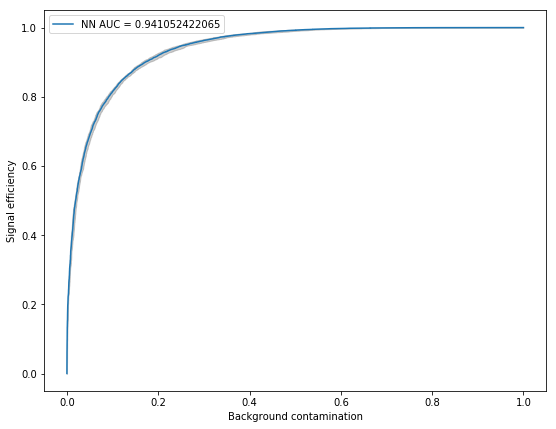

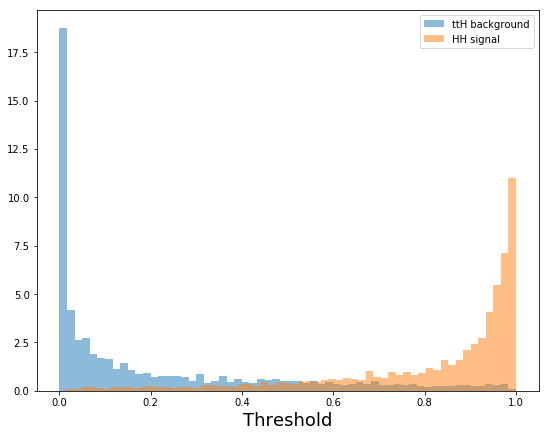

In [8]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []
volatile=True
best_batch_size = bestconf['batch_size']
for train_index, test_index in skf.split(data_hlf, label):
    val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_batch_size, shuffle=False)
    model.eval()
    all_pred = np.zeros(shape=(len(data_hlf[test_index]),2))
    all_label = np.zeros(shape=(len(data_hlf[test_index])))
    criterion= nn.NLLLoss()

    for batch_idx, (particles_data, hlf_data, y_data) in enumerate(val_loader):
        particles_data = particles_data.numpy()
        arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
        arr = [1 if x==0 else x for x in arr]
        arr = np.array(arr)
        sorted_indices_la= np.argsort(-arr)
        particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
        hlf_data = hlf_data[sorted_indices_la]
        particles_data = Variable(particles_data, volatile=volatile).cuda()
        hlf_data = Variable(hlf_data, volatile).cuda()
        t_seq_length= [arr[i] for i in sorted_indices_la]
        particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

        outputs = model(particles_data, hlf_data)

        # Unsort the predictions (to match the original data order)
        # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
        b = np.argsort(sorted_indices_la)
        unsorted_pred = outputs[b].data.cpu().numpy()

        fill_array(all_pred, unsorted_pred, batch_idx, best_batch_size)
        fill_array(all_label, y_data.numpy(), batch_idx, best_batch_size)

    fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])
    
    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
plt.plot(mean_fprs, base_tpr,label="NN AUC = {}".format(mean_area))
plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

with h5py.File("ReallyInclusive_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")


### On the whole dataset

(371406, 6, 7)
(371406, 9)
(371406,)
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2650  |       0.9600      |          0.2915          |
|   0.3724  |       0.9350      |          0.2276          |
|   0.4799  |       0.9000      |          0.1745          |
|   0.7865  |       0.7000      |          0.0542          |
|   0.9145  |       0.5001      |          0.0190          |
|   0.9663  |       0.3000      |          0.0057          |
+-----------+-------------------+--------------------------+


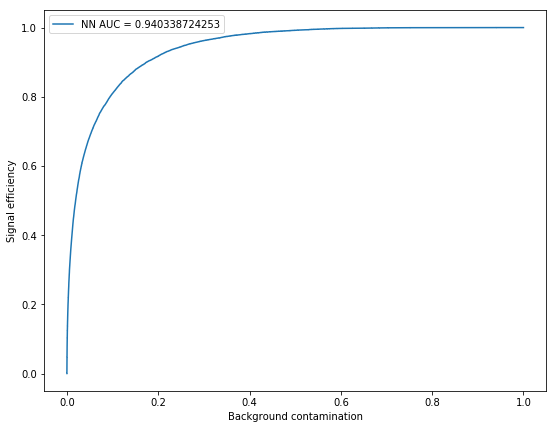

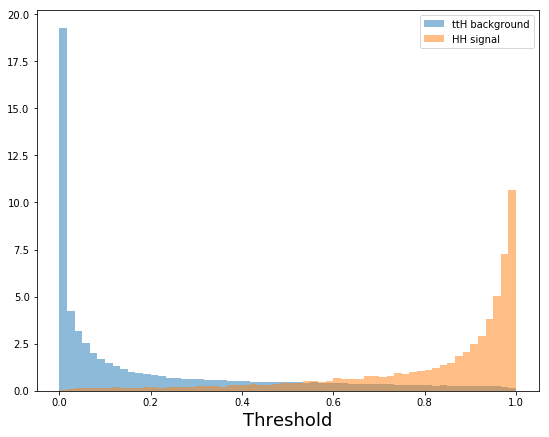

In [9]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value

particles_val = np.concatenate((normed_sig_list, normed_bkg_list))
hlf_val = np.concatenate((normed_sig_hlf, normed_bkg_hlf))
y_val = np.concatenate((np.ones(len(normed_sig_hlf)),np.zeros(len(normed_bkg_hlf))))
print(particles_val.shape)
print(hlf_val.shape)
print(y_val.shape)

test_batch_size = 300

all_pred = np.zeros(shape=(len(y_val),2))
test_loader = DataLoader(ParticleHLF(particles_val, hlf_val, y_val), batch_size = test_batch_size, shuffle=False)

model.eval()
volatile=True

for batch_idx, (particles_data, hlf_data, y_data) in enumerate(test_loader):
    particles_data = particles_data.numpy()
    arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
    arr = [1 if x==0 else x for x in arr]
    arr = np.array(arr)
    sorted_indices_la= np.argsort(-arr)
    particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
    hlf_data = hlf_data[sorted_indices_la]
    particles_data = Variable(particles_data, volatile=volatile).cuda()
    hlf_data = Variable(hlf_data, volatile).cuda()
    t_seq_length= [arr[i] for i in sorted_indices_la]
    particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

    outputs = model(particles_data, hlf_data)

    # Unsort the predictions (to match the original data order)
    # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
    b = np.argsort(sorted_indices_la)
    unsorted_pred = outputs[b].data.cpu().numpy()
    fill_array(all_pred, unsorted_pred, batch_idx, test_batch_size)
    
fpr, tpr, thresholds = roc_curve(y_val, np.exp(all_pred)[:,1])
area = auc(fpr, tpr)

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    NNtable.add_row([thresholds[thres_idx], tpr[thres_idx],  fpr[thres_idx]])
print(NNtable)
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,label="NN AUC = {}".format(area))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

sig_frame = pd.DataFrame.from_records(signp)
bkg_frame = pd.DataFrame.from_records(bkgnp)

sig_frame['NN_score'] = pd.Series(np.exp(all_pred[:len(normed_sig_hlf),1]), index=sig_frame.index)
bkg_frame['NN_score'] = pd.Series(np.exp(all_pred[len(normed_sig_hlf):,1]), index=bkg_frame.index)

### Check mistagged samples

Threshold for bkg mistag: 0.969272750511
Threshold for signal mistag: 0.207515949308


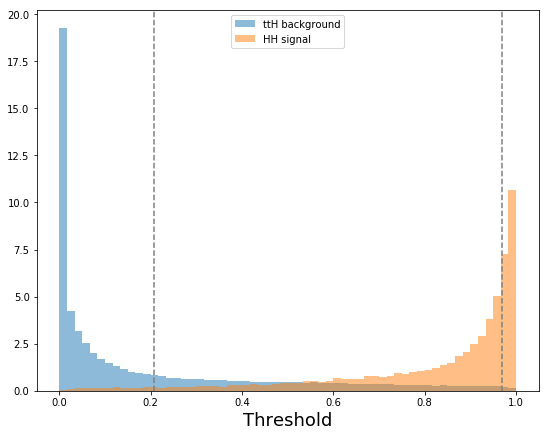

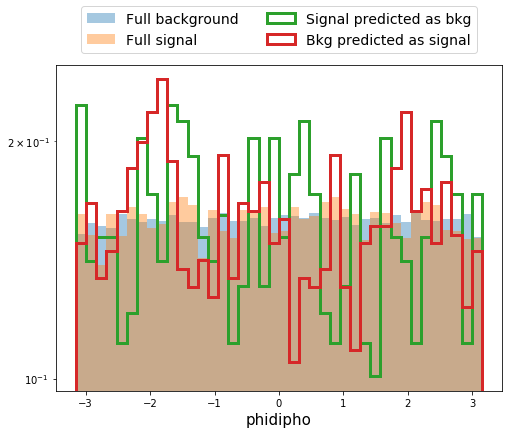

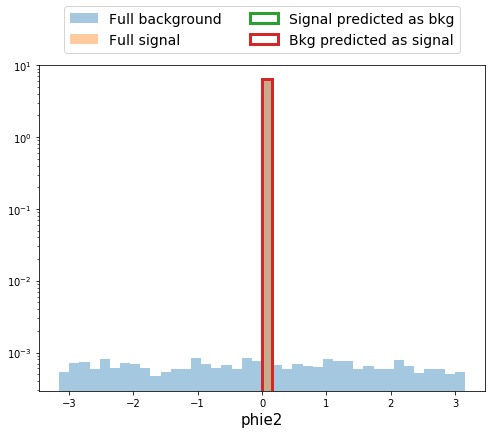

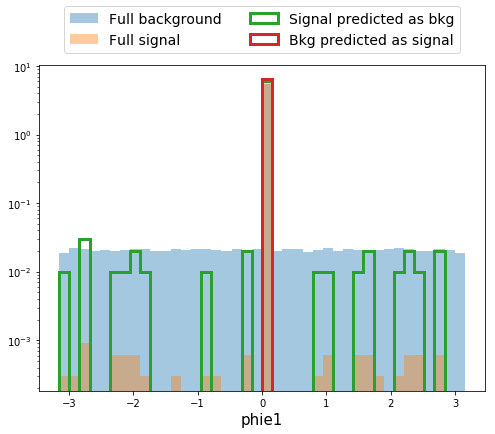

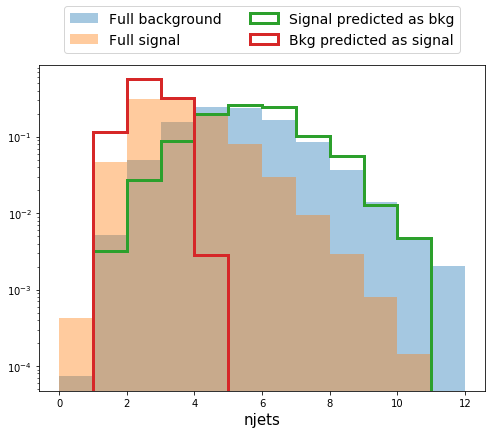

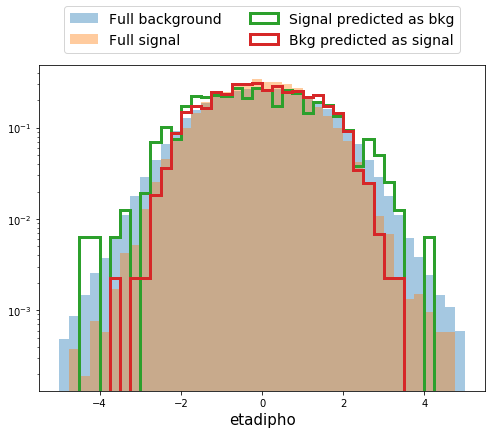

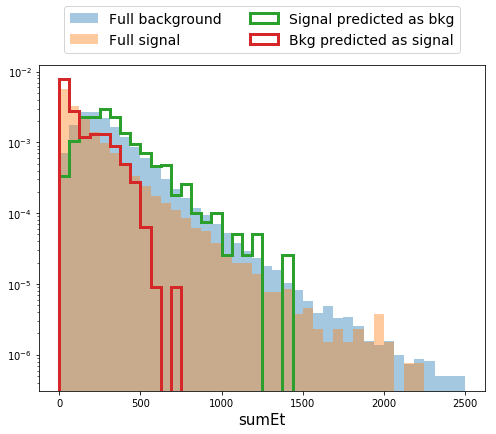

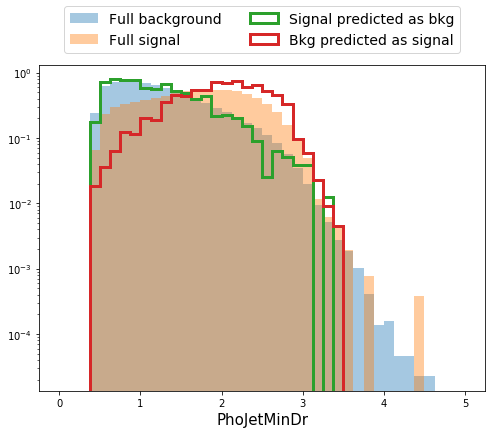

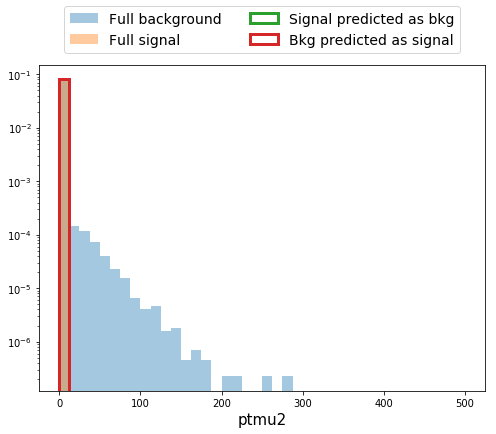

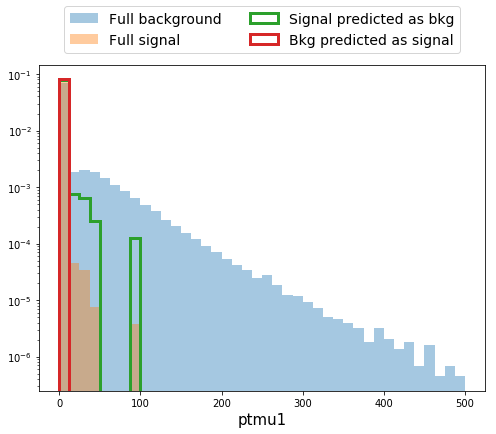

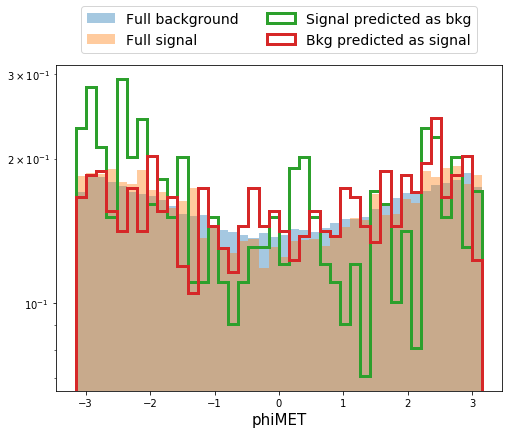

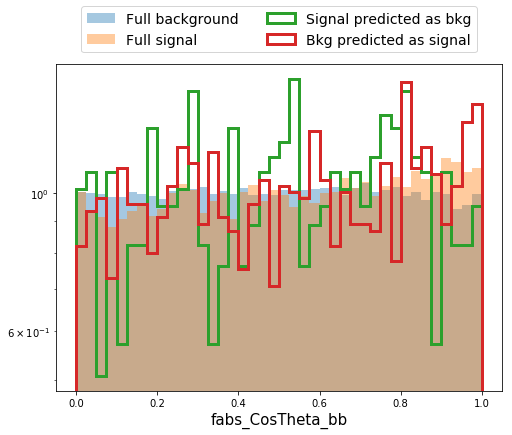

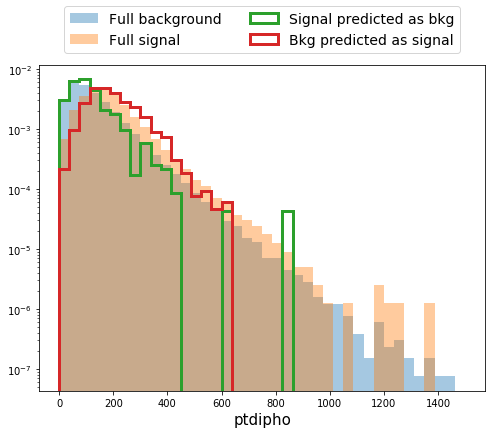

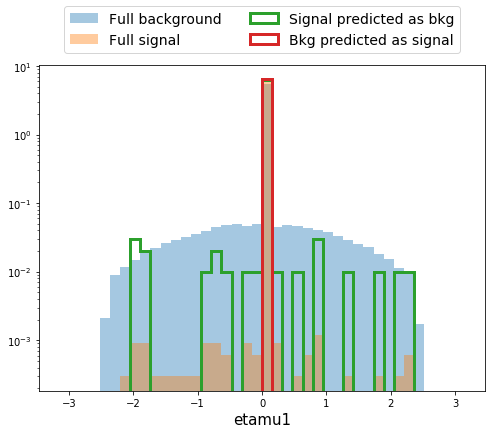

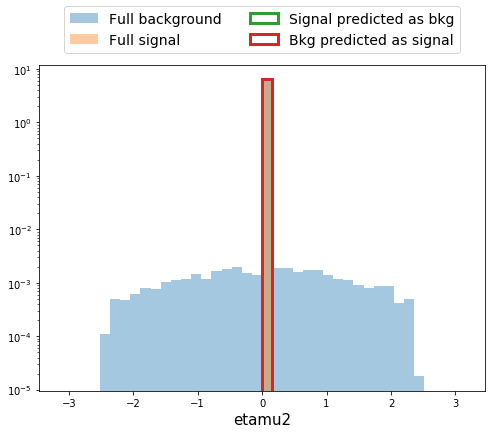

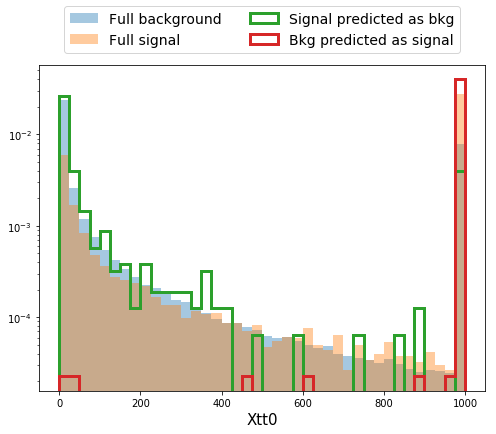

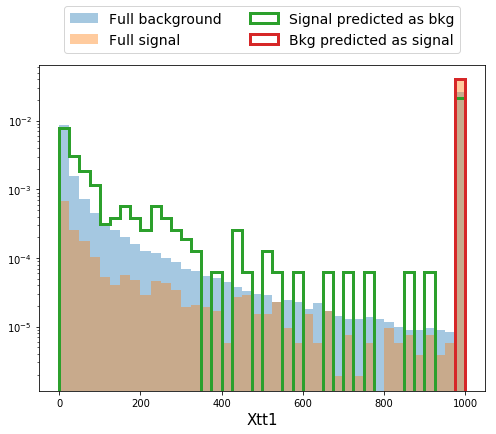

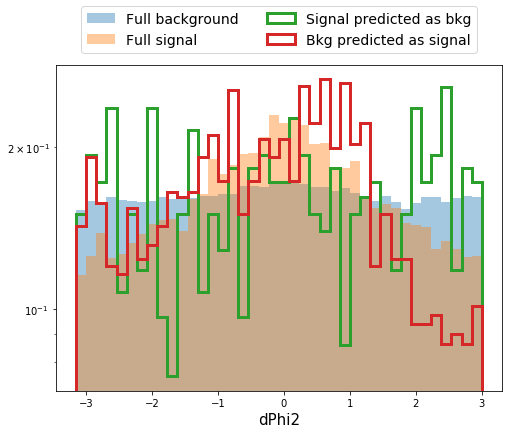

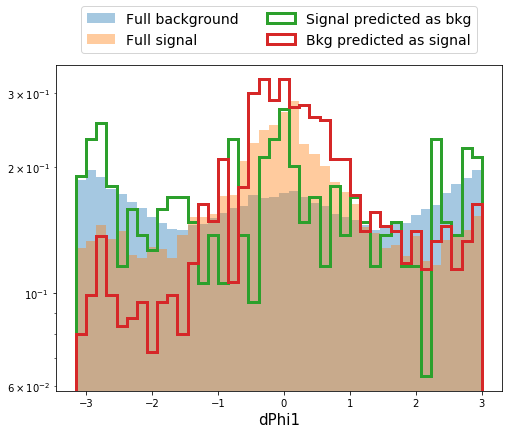

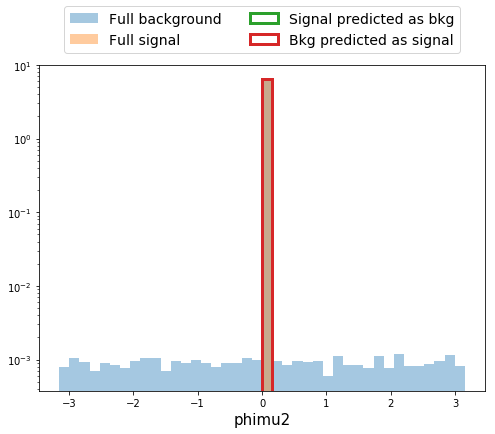

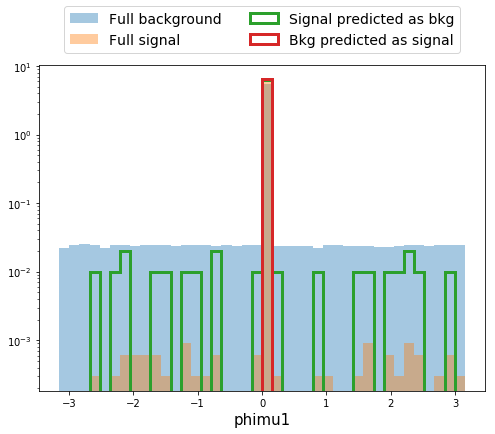

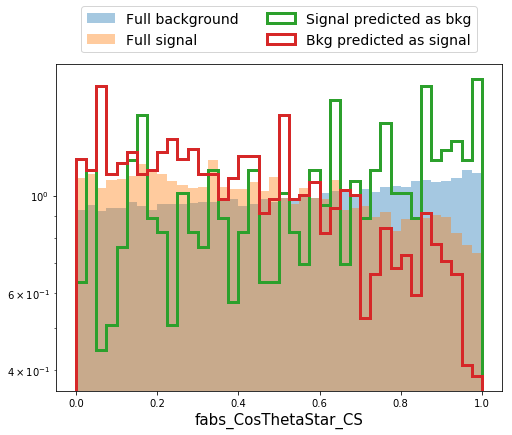

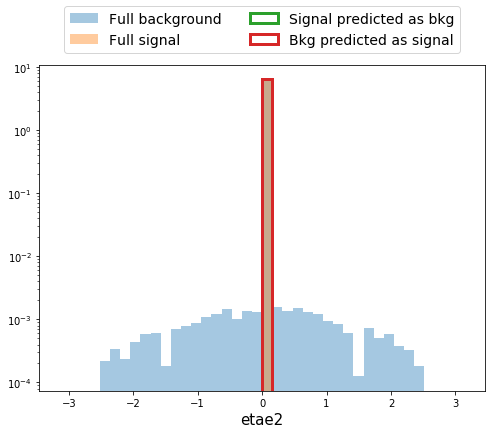

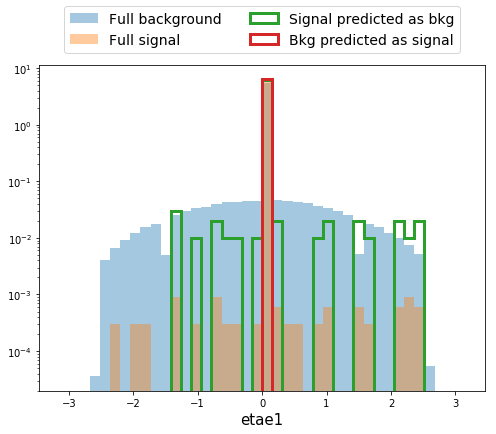

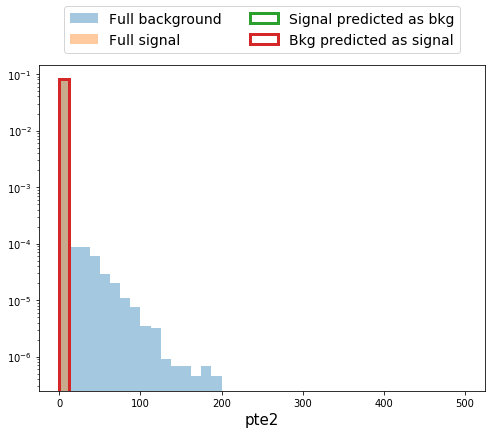

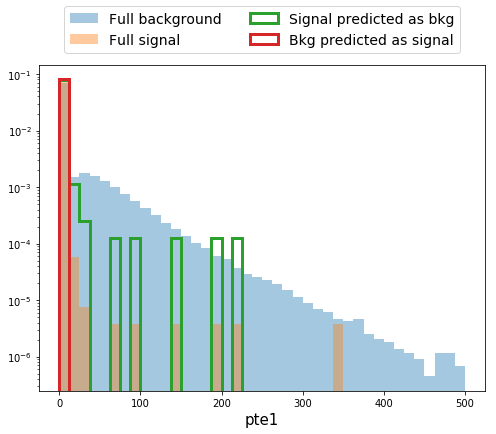

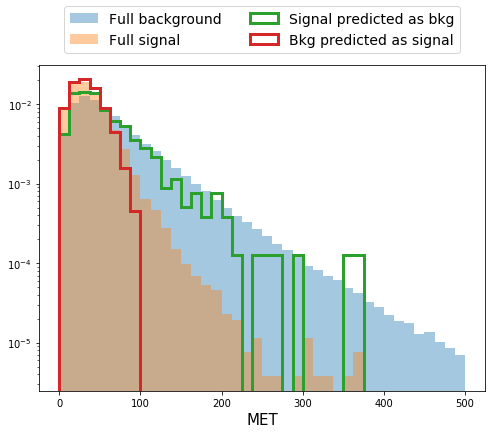

In [33]:
features_to_check = {
    'sumEt': [40, 0, 2500],
    'MET': [40,0,500],
    'phiMET': [40, -3.15, 3.15],
    'dPhi1': [40, -3.15, 3,15],
    'dPhi2': [40, -3.15, 3,15],
    'PhoJetMinDr': [40, 0, 5],
    'njets': [12, 0, 12],
    'Xtt0': [40, 0, 1000],
    'Xtt1': [40, 0, 1000],
    'pte1': [40, 0, 500],
    'pte2': [40, 0, 500],
    'ptmu1': [40, 0, 500],
    'ptmu2': [40, 0, 500],
    'ptdipho': [40, 0, 1500],
    'etae1': [40, -3.15, 3.15],
    'etae2': [40, -3.15, 3.15],
    'etamu1': [40, -3.15, 3.15],
    'etamu2': [40, -3.15, 3.15],
    'etadipho': [40, -5, 5],
    'phie1': [40, -3.15, 3.15],
    'phie2': [40, -3.15, 3.15],
    'phimu1': [40, -3.15, 3.15],
    'phimu2': [40, -3.15, 3.15],
    'phidipho': [40, -3.15, 3.15],
    'fabs_CosThetaStar_CS': [40, 0, 1],
    'fabs_CosTheta_bb': [40, 0, 1]
}

background_mistag_thres = thresholds[np.argmax(fpr>0.005)]
signal_mistag_thres = thresholds[np.argmax(tpr>0.97)]
print("Threshold for bkg mistag: {}".format(background_mistag_thres))
print("Threshold for signal mistag: {}".format(signal_mistag_thres))

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, normed=True)
plt.axvline(background_mistag_thres, ls='--',color='tab:gray')
plt.axvline(signal_mistag_thres, ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)


for feat in features_to_check:

    plt.figure(figsize=(8,6))
    plt.hist(bkg_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Full background',
             histtype='stepfilled',
             alpha=0.4,
             normed=True
             )
    plt.hist(sig_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
              label='Full signal',
              histtype='stepfilled',
             alpha=0.4,
             normed=True,
            )
    plt.hist(sig_frame[feat][sig_frame['NN_score']<signal_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Signal predicted as bkg',
            histtype='step',
            linewidth=3,
             normed=True,
            )
    plt.hist(bkg_frame[feat][bkg_frame['NN_score']>background_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             histtype='step',
             linewidth=3,
             label='Bkg predicted as signal',
             normed=True
            )
    plt.xlabel(feat, fontsize=15)
    plt.yscale('log')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, fontsize=14)


### Check mass sculpting

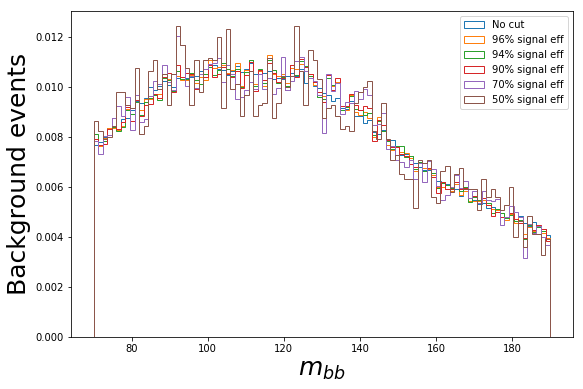

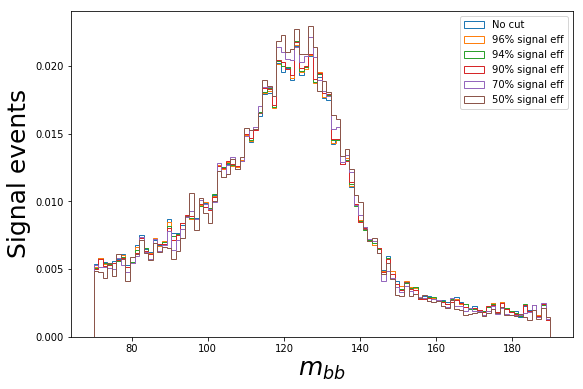

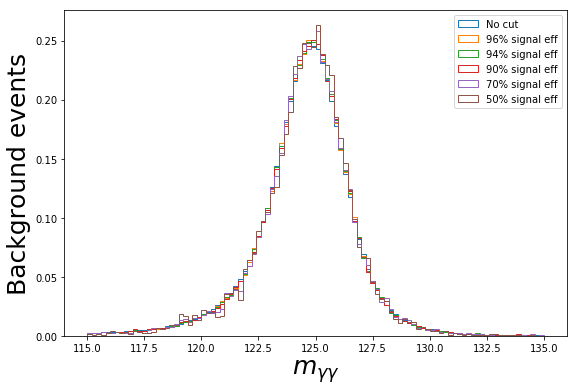

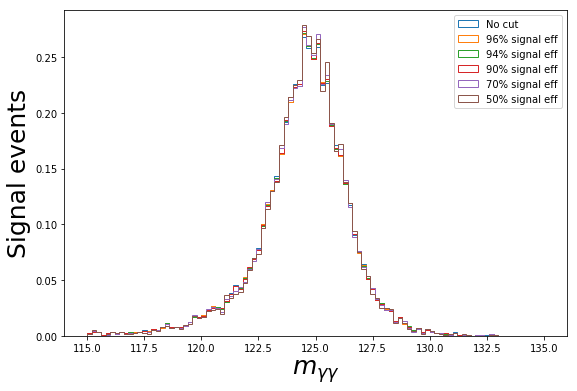

In [58]:
fontsize=25

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut',normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_jj'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_jj'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_gg'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_gg'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, 
             histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

### Benchmark

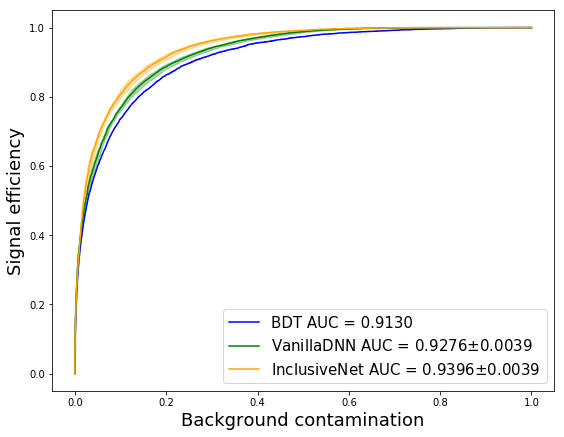

In [138]:
with h5py.File("DNN_ROC.h5","r") as rocfile:
    fpr_dnn = rocfile['FPR'][:]
    dfpr_dnn = rocfile['dFPR'][:]
    tpr_dnn = rocfile['TPR'][:]
    thres_dnn = rocfile['Thresholds'][:]
    area_dnn = auc(fpr_dnn, tpr_dnn)
    fprs_dnn_right = np.minimum(fpr_dnn + dfpr_dnn, 1)
    fprs_dnn_left = np.maximum(fpr_dnn - dfpr_dnn,0)
    darea_dnn = (1-auc(tpr_dnn,fprs_dnn_left))-area_dnn
    
with h5py.File("BDT_ROC.h5","r") as rocfile:
    fpr_bdt = rocfile['FPR'][:]
    tpr_bdt = rocfile['TPR'][:]
    thres_bdt = rocfile['Thresholds'][:]
    area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("ReallyInclusive_ROC.h5","r") as rocfile:
    fpr_inc = rocfile['FPR'][:]
    dfpr_inc = rocfile['dFPR'][:]
    tpr_inc = rocfile['TPR'][:]
    thres_inc = rocfile['Thresholds'][:]
    area_inc = auc(fpr_inc, tpr_inc)
    fprs_inc_right = np.minimum(fpr_inc + dfpr_dnn, 1)
    fprs_inc_left = np.maximum(fpr_inc - dfpr_dnn,0)
    darea_inc = (1-auc(tpr_inc,fprs_inc_left))-area_inc

### Compare
plt.figure(figsize=(9,7))

plt.plot(fpr_bdt,tpr_bdt,color='blue',label="BDT AUC = {:.4f}".format(area_bdt))


plt.plot(fpr_dnn,tpr_dnn,color='green',label=r"VanillaDNN AUC = {:.4f}$\pm${:.4f}".format(area_dnn, darea_dnn))
plt.fill_betweenx(tpr_dnn, fprs_dnn_left, fprs_dnn_right, color='green', alpha=0.3)


plt.plot(fpr_inc,tpr_inc,color='orange',label=r"InclusiveNet AUC = {:.4f}$\pm${:.4f}".format(area_inc, darea_inc))
plt.fill_betweenx(tpr_inc, fprs_inc_left, fprs_inc_right, color='orange', alpha=0.3)

plt.xlabel('Background contamination',fontsize=18)
plt.ylabel('Signal efficiency',fontsize=18)
# # plt.xlim(0.01,0.6)
# # plt.ylim(0.2,1)
# plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
# plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.legend(loc='best',fontsize=15)

In [141]:
TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5]

table = PrettyTable(['Signal Efficiency','BDT','VanillaDNN','InclusiveNet'])
table.get_string(title="Background contamination at different signal efficiencies")
table.float_format = ".2"
for TPR_threshold in TPR_thresholds:
    thres_dnn = np.argmax(tpr_dnn>TPR_threshold)
    thres_bdt = np.argmax(tpr_bdt>TPR_threshold)
    thres_inc = np.argmax(tpr_inc>TPR_threshold)

    table.add_row(["{:.2f}%".format(100*(tpr_dnn[thres_dnn])),  "{:.2f}%".format(100*fpr_bdt[thres_bdt]), "({:.2f} +/- {:.2f})%".format(100*fpr_dnn[thres_dnn], 100*dfpr_dnn[thres_dnn]), "({:.2f} +/- {:.2f})%".format(100*fpr_inc[thres_inc], 100*dfpr_inc[thres_inc])])
print(table.get_string(title="Background contamination at different signal efficiencies"))

+-------------------+--------+-------------------+-------------------+
| Signal Efficiency |  BDT   |     VanillaDNN    |    InclusiveNet   |
+-------------------+--------+-------------------+-------------------+
|       96.02%      | 42.49% | (35.61 +/- 1.40)% | (29.36 +/- 0.91)% |
|       93.52%      | 33.38% | (28.52 +/- 1.27)% | (23.06 +/- 0.28)% |
|       90.02%      | 25.47% | (21.86 +/- 0.99)% | (17.97 +/- 0.59)% |
|       70.01%      | 8.30%  |  (6.97 +/- 0.37)% |  (5.51 +/- 0.25)% |
|       50.01%      | 2.81%  |  (2.36 +/- 0.25)% |  (1.95 +/- 0.17)% |
+-------------------+--------+-------------------+-------------------+


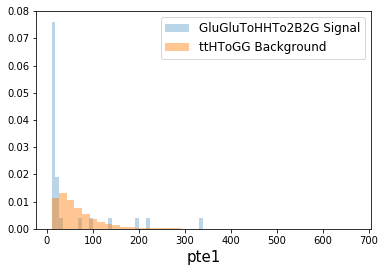

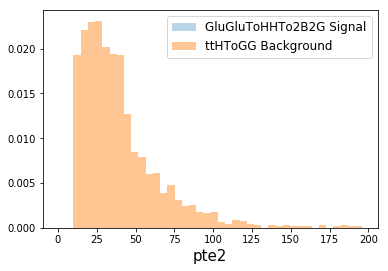

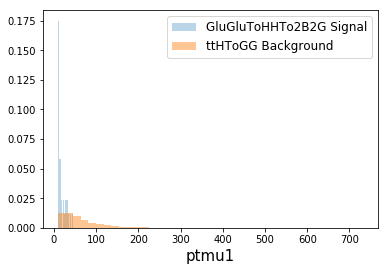

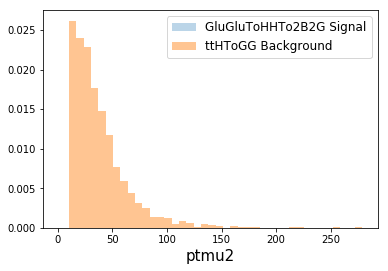

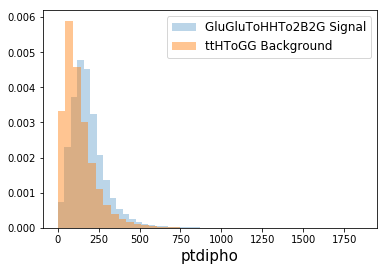

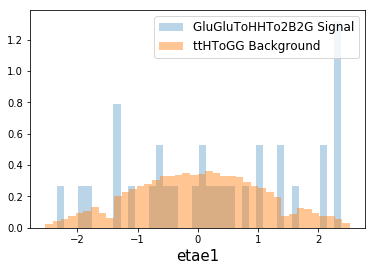

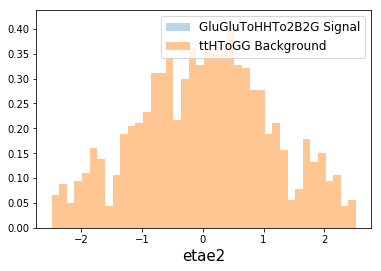

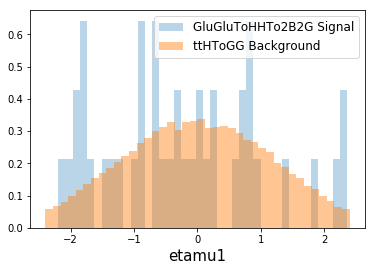

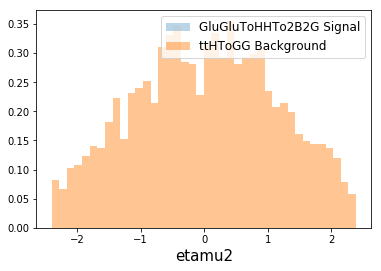

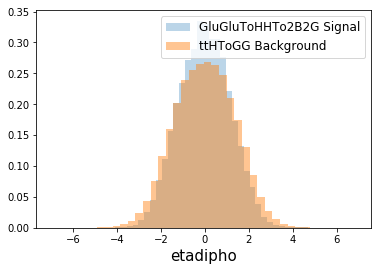

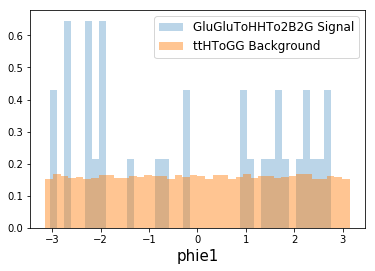

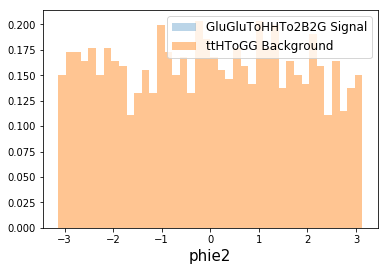

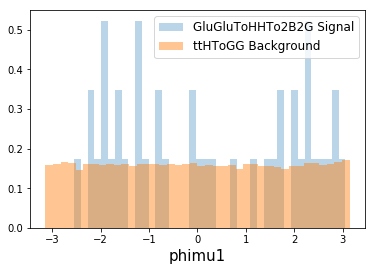

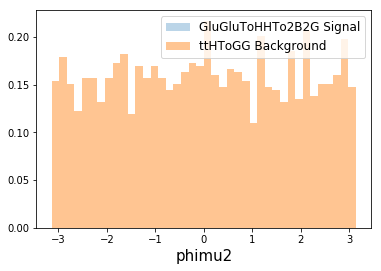

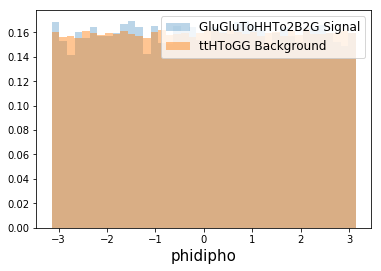

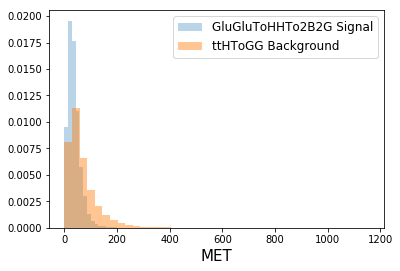

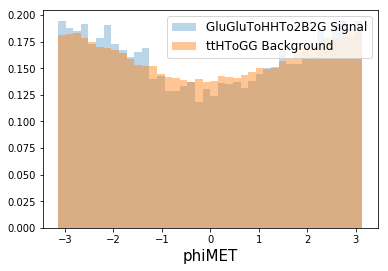

In [78]:
features = ['pte1','pte2','ptmu1','ptmu2','ptdipho',
            'etae1','etae2','etamu1','etamu2','etadipho',
            'phie1','phie2','phimu1','phimu2','phidipho',
            'MET','phiMET']

for fea in features:
    plt.figure()
    plt.hist(sig_frame[fea][sig_frame[fea]!=0], bins=40, normed=True, 
             histtype='stepfilled', alpha=0.3, label='GluGluToHHTo2B2G Signal')
    plt.hist(bkg_frame[fea][bkg_frame[fea]!=0], bins=40, normed=True, 
             histtype='stepfilled', alpha=0.45, label='ttHToGG Background')
    plt.xlabel(fea,fontsize=15)
    plt.legend(loc='best',fontsize=12)